# Aethalometer Data Visualization: PKL & CSV Files
## Comprehensive Graphing and Analysis Using the Modular Aethalometer System

This notebook demonstrates how to load and visualize aethalometer data from both **PKL** and **CSV** files using the aethmodular system. We'll create comprehensive visualizations including:

- Time series plots
- Multi-wavelength comparisons
- Source apportionment analysis
- Data quality assessments
- Interactive plotting capabilities

### Key Features:
- **Unified Loading**: Automatic detection of file type (.pkl or .csv)
- **Format Conversion**: Support for both 'standard' and 'JPL' formats
- **Comprehensive Visualization**: Multiple plot types for different analysis needs
- **Data Comparison**: Side-by-side analysis of different datasets
- **Quality Assessment**: Built-in data validation and quality metrics

### Data Sources:
We'll work with example aethalometer data files in both formats to showcase the system's versatility.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add the src directory to the Python path
src_path = str(Path('../src').resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print("📦 Importing Aethmodular System Components...")

# Import core data loading functions
try:
    from data.loaders.aethalometer import (
        AethalometerPKLLoader, 
        AethalometerCSVLoader,
        load_aethalometer_data
    )
    print("✅ Data loaders imported successfully")
except ImportError as e:
    print(f"⚠️ Data loaders import error: {e}")

# Import analysis modules
try:
    from analysis.bc.black_carbon_analyzer import BlackCarbonAnalyzer
    from analysis.bc.source_apportionment import SourceApportionmentAnalyzer
    print("✅ Analysis modules imported successfully")
except ImportError as e:
    print(f"⚠️ Analysis modules import error: {e}")

# Import visualization utilities
try:
    from utils.plotting import AethalometerPlotter
    from config.plotting import setup_plotting_style
    print("✅ Plotting utilities imported successfully")
except ImportError as e:
    print(f"⚠️ Plotting utilities import error: {e}")

# Import utility functions
try:
    from utils.file_io import ensure_output_directory
    from utils.data_validation import DataValidator
    print("✅ Utility functions imported successfully")
except ImportError as e:
    print(f"⚠️ Utility functions import error: {e}")

# Setup plotting configuration
try:
    setup_plotting_style()
    print("✅ Plotting style configured")
except:
    # Fallback plotting style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    print("✅ Fallback plotting style applied")

# Configure plot settings
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print(f"\n🎯 Aethmodular Visualization System Ready!")
print(f"📁 Working directory: {os.getcwd()}")
print(f"🔗 Source path: {src_path}")

📦 Importing Aethmodular System Components...
⚠️ Data loaders import error: No module named 'data'
⚠️ Analysis modules import error: No module named 'analysis'
⚠️ Plotting utilities import error: No module named 'utils'
⚠️ Utility functions import error: No module named 'utils'
✅ Fallback plotting style applied

🎯 Aethmodular Visualization System Ready!
📁 Working directory: /Users/ahzs645/Github/aethmodular/notebooks/archive
🔗 Source path: /Users/ahzs645/Github/aethmodular/notebooks/src


## 1. Data Loading Functions

Let's create helper functions to demonstrate loading data from different file types and formats.

In [2]:
def load_and_summarize_data(file_path, file_type="auto", output_format="jpl", site_filter=None):
    """
    Load aethalometer data and provide comprehensive summary
    
    Parameters:
    -----------
    file_path : str
        Path to the data file
    file_type : str
        File type ('pkl', 'csv', or 'auto' for auto-detection)
    output_format : str
        Output format ('jpl' or 'standard')
    site_filter : str, optional
        Filter data by specific site
        
    Returns:
    --------
    tuple
        (dataframe, summary_dict)
    """
    
    print(f"📁 Loading: {Path(file_path).name}")
    print(f"🔍 File type: {file_type}")
    print(f"📊 Output format: {output_format}")
    
    try:
        # Use the unified loading function
        df = load_aethalometer_data(
            file_path, 
            output_format=output_format,
            site_filter=site_filter
        )
        
        # Generate summary
        summary = {
            'file_name': Path(file_path).name,
            'file_type': Path(file_path).suffix,
            'shape': df.shape,
            'columns': len(df.columns),
            'memory_mb': df.memory_usage(deep=True).sum() / 1024**2,
            'bc_columns': [col for col in df.columns if '.BCc' in col or 'BC' in col.upper()],
            'atn_columns': [col for col in df.columns if '.ATN' in col or 'ATN' in col.upper()],
            'time_range': None,
            'missing_data_pct': (df.isnull().sum().sum() / df.size) * 100
        }
        
        # Try to get time range
        if hasattr(df.index, 'min'):
            try:
                summary['time_range'] = (df.index.min(), df.index.max())
            except:
                pass
        
        print(f"✅ Successfully loaded: {df.shape[0]} rows × {df.shape[1]} columns")
        print(f"📊 Memory usage: {summary['memory_mb']:.2f} MB")
        print(f"🧮 BC columns found: {len(summary['bc_columns'])}")
        print(f"📈 ATN columns found: {len(summary['atn_columns'])}")
        
        return df, summary
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None, None

def create_sample_data_if_needed():
    """
    Create sample data for demonstration if no data files are available
    """
    print("🔧 Creating sample aethalometer data for demonstration...")
    
    # Generate sample datetime index
    dates = pd.date_range('2024-01-01', '2024-01-31', freq='1H')
    n_samples = len(dates)
    
    # Create realistic aethalometer data
    np.random.seed(42)
    
    # Base BC concentration with diurnal pattern
    hour_factor = np.sin(2 * np.pi * dates.hour / 24) * 0.3 + 1
    base_bc = 2.5 + hour_factor + np.random.normal(0, 0.5, n_samples)
    base_bc = np.maximum(base_bc, 0.1)  # Ensure positive values
    
    # Create sample data dictionary
    data = {
        # Standard format columns
        'BC1': base_bc * (1 + np.random.normal(0, 0.1, n_samples)),
        'BC2': base_bc * (1 + np.random.normal(0, 0.15, n_samples)),
        'BC3': base_bc * (1 + np.random.normal(0, 0.12, n_samples)),
        'BC4': base_bc * (1 + np.random.normal(0, 0.08, n_samples)),
        'BC5': base_bc * (1 + np.random.normal(0, 0.13, n_samples)),
        'BC6': base_bc * (1 + np.random.normal(0, 0.09, n_samples)),
        'BC7': base_bc * (1 + np.random.normal(0, 0.11, n_samples)),
        
        # Attenuation data
        'ATN1': np.random.exponential(50, n_samples),
        'ATN2': np.random.exponential(45, n_samples),
        'ATN3': np.random.exponential(40, n_samples),
        'ATN4': np.random.exponential(35, n_samples),
        'ATN5': np.random.exponential(42, n_samples),
        'ATN6': np.random.exponential(38, n_samples),
        'ATN7': np.random.exponential(41, n_samples),
        
        # Flow and other parameters
        'flow': 2.0 + np.random.normal(0, 0.1, n_samples),
        'temp': 20 + 5 * np.sin(2 * np.pi * dates.dayofyear / 365) + np.random.normal(0, 2, n_samples),
        'pressure': 1013 + np.random.normal(0, 5, n_samples),
        
        # Quality indicators
        'status': np.random.choice([0, 1], n_samples, p=[0.05, 0.95]),
        'site': 'DEMO_SITE'
    }
    
    # Create DataFrame
    df_sample = pd.DataFrame(data, index=dates)
    df_sample.index.name = 'datetime'
    
    print(f"✅ Created sample data: {df_sample.shape[0]} rows × {df_sample.shape[1]} columns")
    
    return df_sample

# Test the loading functions
print("🧪 Testing data loading capabilities...")

🧪 Testing data loading capabilities...


## 2. Load Example Data

Let's load data from different sources to demonstrate the system's versatility. We'll handle cases where specific files might not be available by creating sample data.

In [3]:
# Define potential data file paths (adjust these paths based on your actual data location)
potential_data_files = [
    # PKL files
    "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Kyan Data/Mergedcleaned and uncleaned MA350 data20250707030704/df_uncleaned_Jacros_API_and_OG.pkl",

    
    # CSV files
    "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Raw/Jacros_MA350_1-min_2022-2024_Cleaned.csv",
]

# Storage for loaded datasets
datasets = {}
summaries = {}

print("🔍 Searching for available data files...")

# Try to load real data files
for file_path in potential_data_files:
    if os.path.exists(file_path):
        print(f"\n📁 Found: {file_path}")
        
        # Determine file type from extension
        file_ext = Path(file_path).suffix.lower()
        
        try:
            if file_ext == '.pkl':
                df, summary = load_and_summarize_data(file_path, file_type="pkl", output_format="jpl")
                if df is not None:
                    datasets[f'pkl_data_{len(datasets)}'] = df
                    summaries[f'pkl_data_{len(summaries)}'] = summary
                    
            elif file_ext == '.csv':
                df, summary = load_and_summarize_data(file_path, file_type="csv", output_format="jpl")
                if df is not None:
                    datasets[f'csv_data_{len(datasets)}'] = df
                    summaries[f'csv_data_{len(summaries)}'] = summary
                    
        except Exception as e:
            print(f"⚠️ Could not load {file_path}: {e}")

# If no real data was found, create sample data
if not datasets:
    print("\n🔧 No data files found. Creating sample datasets for demonstration...")
    
    # Create sample PKL-style data
    df_pkl_sample = create_sample_data_if_needed()
    datasets['sample_pkl'] = df_pkl_sample
    summaries['sample_pkl'] = {
        'file_name': 'sample_pkl_data',
        'file_type': '.pkl',
        'shape': df_pkl_sample.shape,
        'columns': len(df_pkl_sample.columns),
        'bc_columns': [col for col in df_pkl_sample.columns if 'BC' in col],
        'atn_columns': [col for col in df_pkl_sample.columns if 'ATN' in col],
        'time_range': (df_pkl_sample.index.min(), df_pkl_sample.index.max())
    }
    
    # Create sample CSV-style data (slightly different format)
    df_csv_sample = df_pkl_sample.copy()
    # Modify some column names to simulate CSV format differences
    csv_columns = {}
    for col in df_csv_sample.columns:
        if 'BC' in col:
            csv_columns[col] = f'BlackCarbon_{col}'
        elif 'ATN' in col:
            csv_columns[col] = f'Attenuation_{col}'
    df_csv_sample = df_csv_sample.rename(columns=csv_columns)
    
    datasets['sample_csv'] = df_csv_sample
    summaries['sample_csv'] = {
        'file_name': 'sample_csv_data',
        'file_type': '.csv',
        'shape': df_csv_sample.shape,
        'columns': len(df_csv_sample.columns),
        'bc_columns': [col for col in df_csv_sample.columns if 'BlackCarbon' in col],
        'atn_columns': [col for col in df_csv_sample.columns if 'Attenuation' in col],
        'time_range': (df_csv_sample.index.min(), df_csv_sample.index.max())
    }

print(f"\n🎯 Successfully loaded {len(datasets)} datasets:")
for name, summary in summaries.items():
    print(f"   📊 {name}: {summary['shape'][0]} rows, {summary['columns']} columns ({summary['file_type']} format)")

🔍 Searching for available data files...

📁 Found: /Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Kyan Data/Mergedcleaned and uncleaned MA350 data20250707030704/df_uncleaned_Jacros_API_and_OG.pkl
📁 Loading: df_uncleaned_Jacros_API_and_OG.pkl
🔍 File type: pkl
📊 Output format: jpl
❌ Error loading data: name 'load_aethalometer_data' is not defined

📁 Found: /Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Raw/Jacros_MA350_1-min_2022-2024_Cleaned.csv
📁 Loading: Jacros_MA350_1-min_2022-2024_Cleaned.csv
🔍 File type: csv
📊 Output format: jpl
❌ Error loading data: name 'load_aethalometer_data' is not defined

🔧 No data files found. Creating sample datasets for demonstration...
🔧 Creating sample aethalometer data for demonstration...
✅ Created sample data: 721 rows × 19 columns

🎯 Successfully loaded 2 

## 3. Data Overview and Comparison

Let's examine the structure and characteristics of our loaded datasets.

In [4]:
# Display comprehensive data overview
for dataset_name, df in datasets.items():
    print("=" * 80)
    print(f"📊 DATASET: {dataset_name.upper()}")
    print("=" * 80)
    
    summary = summaries[dataset_name]
    
    # Basic information
    print(f"📁 File: {summary['file_name']} ({summary['file_type']})")
    print(f"📐 Shape: {summary['shape'][0]:,} rows × {summary['shape'][1]} columns")
    if 'memory_mb' in summary:
        print(f"💾 Memory: {summary['memory_mb']:.2f} MB")
    
    # Time range information
    if summary.get('time_range'):
        start_time, end_time = summary['time_range']
        duration = end_time - start_time
        print(f"⏱️ Time range: {start_time} to {end_time}")
        print(f"⏳ Duration: {duration}")
    
    # Column information
    print(f"\n📋 Column breakdown:")
    print(f"   🔴 BC columns: {len(summary['bc_columns'])}")
    if summary['bc_columns']:
        print(f"      {summary['bc_columns'][:5]}{'...' if len(summary['bc_columns']) > 5 else ''}")
    
    print(f"   📈 ATN columns: {len(summary['atn_columns'])}")
    if summary['atn_columns']:
        print(f"      {summary['atn_columns'][:5]}{'...' if len(summary['atn_columns']) > 5 else ''}")
    
    # Data quality
    if 'missing_data_pct' in summary:
        print(f"   ❓ Missing data: {summary['missing_data_pct']:.2f}%")
    
    # Sample of the data
    print(f"\n🔍 First 3 rows:")
    display(df.head(3))
    
    print(f"\n📊 Basic statistics for BC columns:")
    bc_cols = summary['bc_columns'][:5]  # Show stats for first 5 BC columns
    if bc_cols:
        display(df[bc_cols].describe())
    
    print("\n")

📊 DATASET: PKL_DATA_0
📁 File: df_uncleaned_Jacros_API_and_OG.pkl (.pkl)
📐 Shape: 1,665,156 rows × 239 columns
💾 Memory: 7443.05 MB
⏱️ Time range: 0 to 1665155
⏳ Duration: 1665155

📋 Column breakdown:
   🔴 BC columns: 30
      ['Blue BC1', 'Blue BC2', 'Blue.BCc', 'Green BC1', 'Green BC2']...
   📈 ATN columns: 25
      ['Blue.ATN1', 'Blue.ATN2', 'Green.ATN1', 'Green.ATN2', 'IR.ATN1']...
   ❓ Missing data: 45.16%

🔍 First 3 rows:


,datetime_local,index,Unnamed: 0,Accel X,Accel Y,Accel Z,Blue.ATN1,Blue.ATN2,Blue BC1,Blue BC2,...,transfer,transferProtocol,unixtime,updated,viaBacklog,source,App version,Battery remaining (%),Data format version,GPS speed (km/h)
0,2021-01-09 16:38:00,910527,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.610210e+12,mqtt,1.610210e+12,1.676347e+12,NaN,api,NaN,NaN,NaN,NaN
1,2021-01-09 16:39:00,910533,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.610210e+12,mqtt,1.610210e+12,1.676347e+12,NaN,api,NaN,NaN,NaN,NaN
2,2021-01-09 16:40:00,910534,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.610210e+12,mqtt,1.610210e+12,1.676347e+12,NaN,api,NaN,NaN,NaN,NaN



📊 Basic statistics for BC columns:


,Blue BC1,Blue BC2,Blue.BCc,Green BC1,Green BC2
count,1.593671e+06,1.593671e+06,1.593671e+06,1.593671e+06,1.593671e+06
mean,4.006365e+03,4.435956e+03,8.106670e+03,4.087241e+03,4.498962e+03
std,1.149150e+04,4.822661e+04,5.909516e+05,1.089203e+04,4.515579e+04
min,-4.051440e+06,-4.340906e+06,-2.343295e+08,-3.289209e+06,-4.258620e+06
25%,1.310000e+03,1.491000e+03,2.715000e+03,1.365000e+03,1.539000e+03
50%,2.427000e+03,2.753000e+03,5.213000e+03,2.511000e+03,2.824000e+03
75%,4.665000e+03,5.212000e+03,9.705000e+03,4.775000e+03,5.294000e+03
max,5.186487e+06,5.954762e+07,3.520764e+08,4.663787e+06,5.562816e+07




📊 DATASET: CSV_DATA_1
📁 File: Jacros_MA350_1-min_2022-2024_Cleaned.csv (.csv)
📐 Shape: 1,095,086 rows × 77 columns
💾 Memory: 940.18 MB
⏱️ Time range: 0 to 1095085
⏳ Duration: 1095085

📋 Column breakdown:
   🔴 BC columns: 15
      ['UV BC1', 'UV BC2', 'UV BCc', 'Blue BC1', 'Blue BC2']...
   📈 ATN columns: 10
      ['UV ATN1', 'UV ATN2', 'Blue ATN1', 'Blue ATN2', 'Green ATN1']...
   ❓ Missing data: 1.30%

🔍 First 3 rows:


,Serial number,Time (UTC),Datum ID,Session ID,Data format version,Firmware version,App version,Timezone offset (mins),Date local (yyyy/MM/dd),Time local (hh:mm:ss),...,Green BC1,Green BC2,Green BCc,Red BC1,Red BC2,Red BCc,IR BC1,IR BC2,IR BCc,Readable status
0,MA350-0238,2022-04-12T09:46:01Z,26133,12,1,1.1,1.4,0,2022-04-12,9:46:01 AM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MA350-0238,2022-04-12T09:47:01Z,26134,12,1,1.1,1.4,0,2022-04-12,9:47:01 AM,...,18208.0,17175.0,18208.0,17685.0,16620.0,17685.0,18120.0,16389.0,18120.0,NaN
2,MA350-0238,2022-04-12T09:48:01Z,26135,12,1,1.1,1.4,0,2022-04-12,9:48:01 AM,...,11178.0,10474.0,11178.0,10834.0,10057.0,10834.0,10784.0,9686.0,10784.0,NaN



📊 Basic statistics for BC columns:


,UV BC1,UV BC2,UV BCc,Blue BC1,Blue BC2
count,1.094754e+06,1.094754e+06,1.094754e+06,1.094754e+06,1.094754e+06
mean,3.945996e+03,4.375318e+03,7.759995e+03,4.235480e+03,4.683869e+03
std,4.841722e+03,5.169150e+03,8.519410e+03,5.003097e+03,5.363181e+03
min,-5.640000e+02,-1.900000e+03,-2.118480e+05,-5.830000e+02,-8.040000e+02
25%,1.301000e+03,1.494000e+03,2.914000e+03,1.450000e+03,1.649000e+03
50%,2.405000e+03,2.742000e+03,5.295000e+03,2.648000e+03,2.991000e+03
75%,4.673000e+03,5.217000e+03,9.428000e+03,5.042000e+03,5.595000e+03
max,3.527160e+05,3.811230e+05,5.092190e+05,3.809220e+05,4.150550e+05


## 4. Time Series Visualization

Let's create comprehensive time series plots for our datasets, focusing on Black Carbon measurements.

In [1]:
def plot_improved_time_series(datasets, summaries, max_cols=5):
    """
    Create improved time series plots with proper datetime handling
    """
    
    # Determine how many subplots we need
    n_datasets = len(datasets)
    fig, axes = plt.subplots(n_datasets, 1, figsize=(16, 6*n_datasets), sharex=True)
    
    if n_datasets == 1:
        axes = [axes]
    
    colors = plt.cm.Set1(np.linspace(0, 1, max_cols))
    
    for idx, (dataset_name, df) in enumerate(datasets.items()):
        ax = axes[idx]
        summary = summaries[dataset_name]
        
        # Get BC columns
        bc_cols = summary['bc_columns'][:max_cols]
        
        # Try to get proper datetime column
        time_col = None
        if 'datetime_local' in df.columns:
            time_col = df['datetime_local']
        elif 'Time (UTC)' in df.columns:
            time_col = pd.to_datetime(df['Time (UTC)'])
        else:
            # Use index as fallback
            time_col = df.index
        
        if bc_cols:
            for i, col in enumerate(bc_cols):
                if col in df.columns:
                    # Filter out extreme outliers for better visualization
                    data = df[col].copy()
                    if data.dtype in ['float64', 'int64']:
                        q99 = data.quantile(0.99)
                        q01 = data.quantile(0.01)
                        data = data.clip(lower=q01, upper=q99)
                    
                    # Plot with transparency to handle overlapping lines
                    ax.plot(time_col, data, 
                           color=colors[i], alpha=0.7, linewidth=1.0,
                           label=col)
        
        ax.set_title(f'Black Carbon Time Series - {dataset_name} ({summary["file_type"]})', 
                    fontsize=14, fontweight='bold')
        ax.set_ylabel('BC Concentration (µg/m³)', fontsize=12)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # Add summary statistics as text
        if bc_cols:
            # Calculate stats from valid data only
            valid_data = []
            for col in bc_cols:
                if col in df.columns:
                    col_data = df[col].dropna()
                    if len(col_data) > 0:
                        valid_data.append(col_data)
            
            if valid_data:
                combined_data = pd.concat(valid_data, ignore_index=True)
                mean_val = combined_data.mean()
                std_val = combined_data.std()
                ax.text(0.02, 0.98, f'Mean: {mean_val:.2f} ± {std_val:.2f} µg/m³', 
                       transform=ax.transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.xlabel('Time', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_bc_distribution_comparison(datasets, summaries):
    """
    Create distribution comparison plots for BC measurements
    """
    
    fig, axes = plt.subplots(2, len(datasets), figsize=(8*len(datasets), 12))
    
    if len(datasets) == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, (dataset_name, df) in enumerate(datasets.items()):
        summary = summaries[dataset_name]
        bc_cols = summary['bc_columns'][:5]  # Use first 5 BC columns
        
        # Box plot (top)
        if bc_cols:
            # Prepare data for boxplot, removing extreme outliers
            plot_data = []
            labels = []
            for col in bc_cols:
                if col in df.columns:
                    data = df[col].dropna()
                    if len(data) > 0:
                        # Remove extreme outliers for better visualization
                        q95 = data.quantile(0.95)
                        q05 = data.quantile(0.05)
                        filtered_data = data[(data >= q05) & (data <= q95)]
                        if len(filtered_data) > 0:
                            plot_data.append(filtered_data)
                            labels.append(col.replace('BC', '').replace('.BCc', ''))
            
            if plot_data:
                bp = axes[0, idx].boxplot(plot_data, labels=labels, patch_artist=True)
                for patch in bp['boxes']:
                    patch.set_facecolor('lightblue')
                
                axes[0, idx].set_title(f'BC Distribution (Box Plot)\n{dataset_name}', fontweight='bold')
                axes[0, idx].set_ylabel('BC Concentration (µg/m³)')
                axes[0, idx].tick_params(axis='x', rotation=45)
                axes[0, idx].grid(True, alpha=0.3)
            
            # Histogram (bottom)
            for i, col in enumerate(bc_cols):
                if col in df.columns:
                    data = df[col].dropna()
                    if len(data) > 0:
                        # Remove extreme outliers for better visualization
                        q95 = data.quantile(0.95)
                        q05 = data.quantile(0.05)
                        filtered_data = data[(data >= q05) & (data <= q95)]
                        if len(filtered_data) > 0:
                            axes[1, idx].hist(filtered_data, alpha=0.6, bins=50, 
                                            label=col.replace('BC', '').replace('.BCc', ''))
            
            axes[1, idx].set_title(f'BC Distribution (Histogram)\n{dataset_name}', fontweight='bold')
            axes[1, idx].set_xlabel('BC Concentration (µg/m³)')
            axes[1, idx].set_ylabel('Frequency')
            axes[1, idx].legend()
            axes[1, idx].grid(True, alpha=0.3)
        else:
            for row in [0, 1]:
                axes[row, idx].text(0.5, 0.5, 'No BC columns available',
                                  ha='center', va='center', transform=axes[row, idx].transAxes)
    
    plt.tight_layout()
    plt.show()

def create_data_summary_comparison(datasets, summaries):
    """
    Create a comprehensive summary comparison table
    """
    
    print("📊 COMPREHENSIVE DATA COMPARISON")
    print("=" * 80)
    
    comparison_data = []
    
    for dataset_name, df in datasets.items():
        summary = summaries[dataset_name]
        bc_cols = summary['bc_columns']
        
        # Calculate statistics for BC columns
        if bc_cols:
            bc_data_list = []
            for col in bc_cols:
                if col in df.columns:
                    col_data = df[col].dropna()
                    if len(col_data) > 0:
                        bc_data_list.append(col_data)
            
            if bc_data_list:
                combined_bc = pd.concat(bc_data_list, ignore_index=True)
                
                comparison_data.append({
                    'Dataset': dataset_name,
                    'File_Type': summary['file_type'],
                    'Total_Rows': summary['shape'][0],
                    'Total_Columns': summary['shape'][1],
                    'BC_Channels': len(bc_cols),
                    'ATN_Channels': len(summary['atn_columns']),
                    'Memory_MB': summary.get('memory_mb', 0),
                    'Missing_Data_%': summary.get('missing_data_pct', 0),
                    'BC_Mean': combined_bc.mean(),
                    'BC_Std': combined_bc.std(),
                    'BC_Min': combined_bc.min(),
                    'BC_Max': combined_bc.max(),
                    'BC_Median': combined_bc.median()
                })
    
    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)
        
        print("📋 Dataset Comparison Table:")
        display(comparison_df.round(2))
        
        # Create visual comparison
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Data volume comparison
        axes[0, 0].bar(comparison_df['Dataset'], comparison_df['Total_Rows'], 
                      color=['skyblue' if '.pkl' in ft else 'lightcoral' 
                            for ft in comparison_df['File_Type']])
        axes[0, 0].set_title('Total Data Points', fontweight='bold')
        axes[0, 0].set_ylabel('Number of Rows')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # BC channels comparison
        axes[0, 1].bar(comparison_df['Dataset'], comparison_df['BC_Channels'],
                      color=['skyblue' if '.pkl' in ft else 'lightcoral' 
                            for ft in comparison_df['File_Type']])
        axes[0, 1].set_title('BC Measurement Channels', fontweight='bold')
        axes[0, 1].set_ylabel('Number of Channels')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Memory usage comparison
        axes[0, 2].bar(comparison_df['Dataset'], comparison_df['Memory_MB'],
                      color=['skyblue' if '.pkl' in ft else 'lightcoral' 
                            for ft in comparison_df['File_Type']])
        axes[0, 2].set_title('Memory Usage', fontweight='bold')
        axes[0, 2].set_ylabel('Memory (MB)')
        axes[0, 2].tick_params(axis='x', rotation=45)
        
        # BC mean comparison
        axes[1, 0].bar(comparison_df['Dataset'], comparison_df['BC_Mean'],
                      color=['skyblue' if '.pkl' in ft else 'lightcoral' 
                            for ft in comparison_df['File_Type']])
        axes[1, 0].set_title('Mean BC Concentration', fontweight='bold')
        axes[1, 0].set_ylabel('BC (µg/m³)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Missing data comparison
        axes[1, 1].bar(comparison_df['Dataset'], comparison_df['Missing_Data_%'],
                      color=['skyblue' if '.pkl' in ft else 'lightcoral' 
                            for ft in comparison_df['File_Type']])
        axes[1, 1].set_title('Missing Data Percentage', fontweight='bold')
        axes[1, 1].set_ylabel('Missing Data (%)')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        # Data range comparison (BC_Max - BC_Min)
        data_range = comparison_df['BC_Max'] - comparison_df['BC_Min']
        axes[1, 2].bar(comparison_df['Dataset'], data_range,
                      color=['skyblue' if '.pkl' in ft else 'lightcoral' 
                            for ft in comparison_df['File_Type']])
        axes[1, 2].set_title('BC Data Range (Max - Min)', fontweight='bold')
        axes[1, 2].set_ylabel('BC Range (µg/m³)')
        axes[1, 2].tick_params(axis='x', rotation=45)
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='skyblue', label='PKL files'),
                          Patch(facecolor='lightcoral', label='CSV files')]
        fig.legend(handles=legend_elements, loc='upper right')
        
        plt.suptitle('Comprehensive Data Comparison: PKL vs CSV Files', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Re-run imports first (since kernel restarted)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from pathlib import Path

# Add the src directory to the Python path
src_path = str(Path('../src').resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print("🔄 Re-importing after nbformat installation...")
print("📈 Creating improved time series visualizations...")

🔄 Re-importing after nbformat installation...
📈 Creating improved time series visualizations...


📈 Creating improved time series plots...


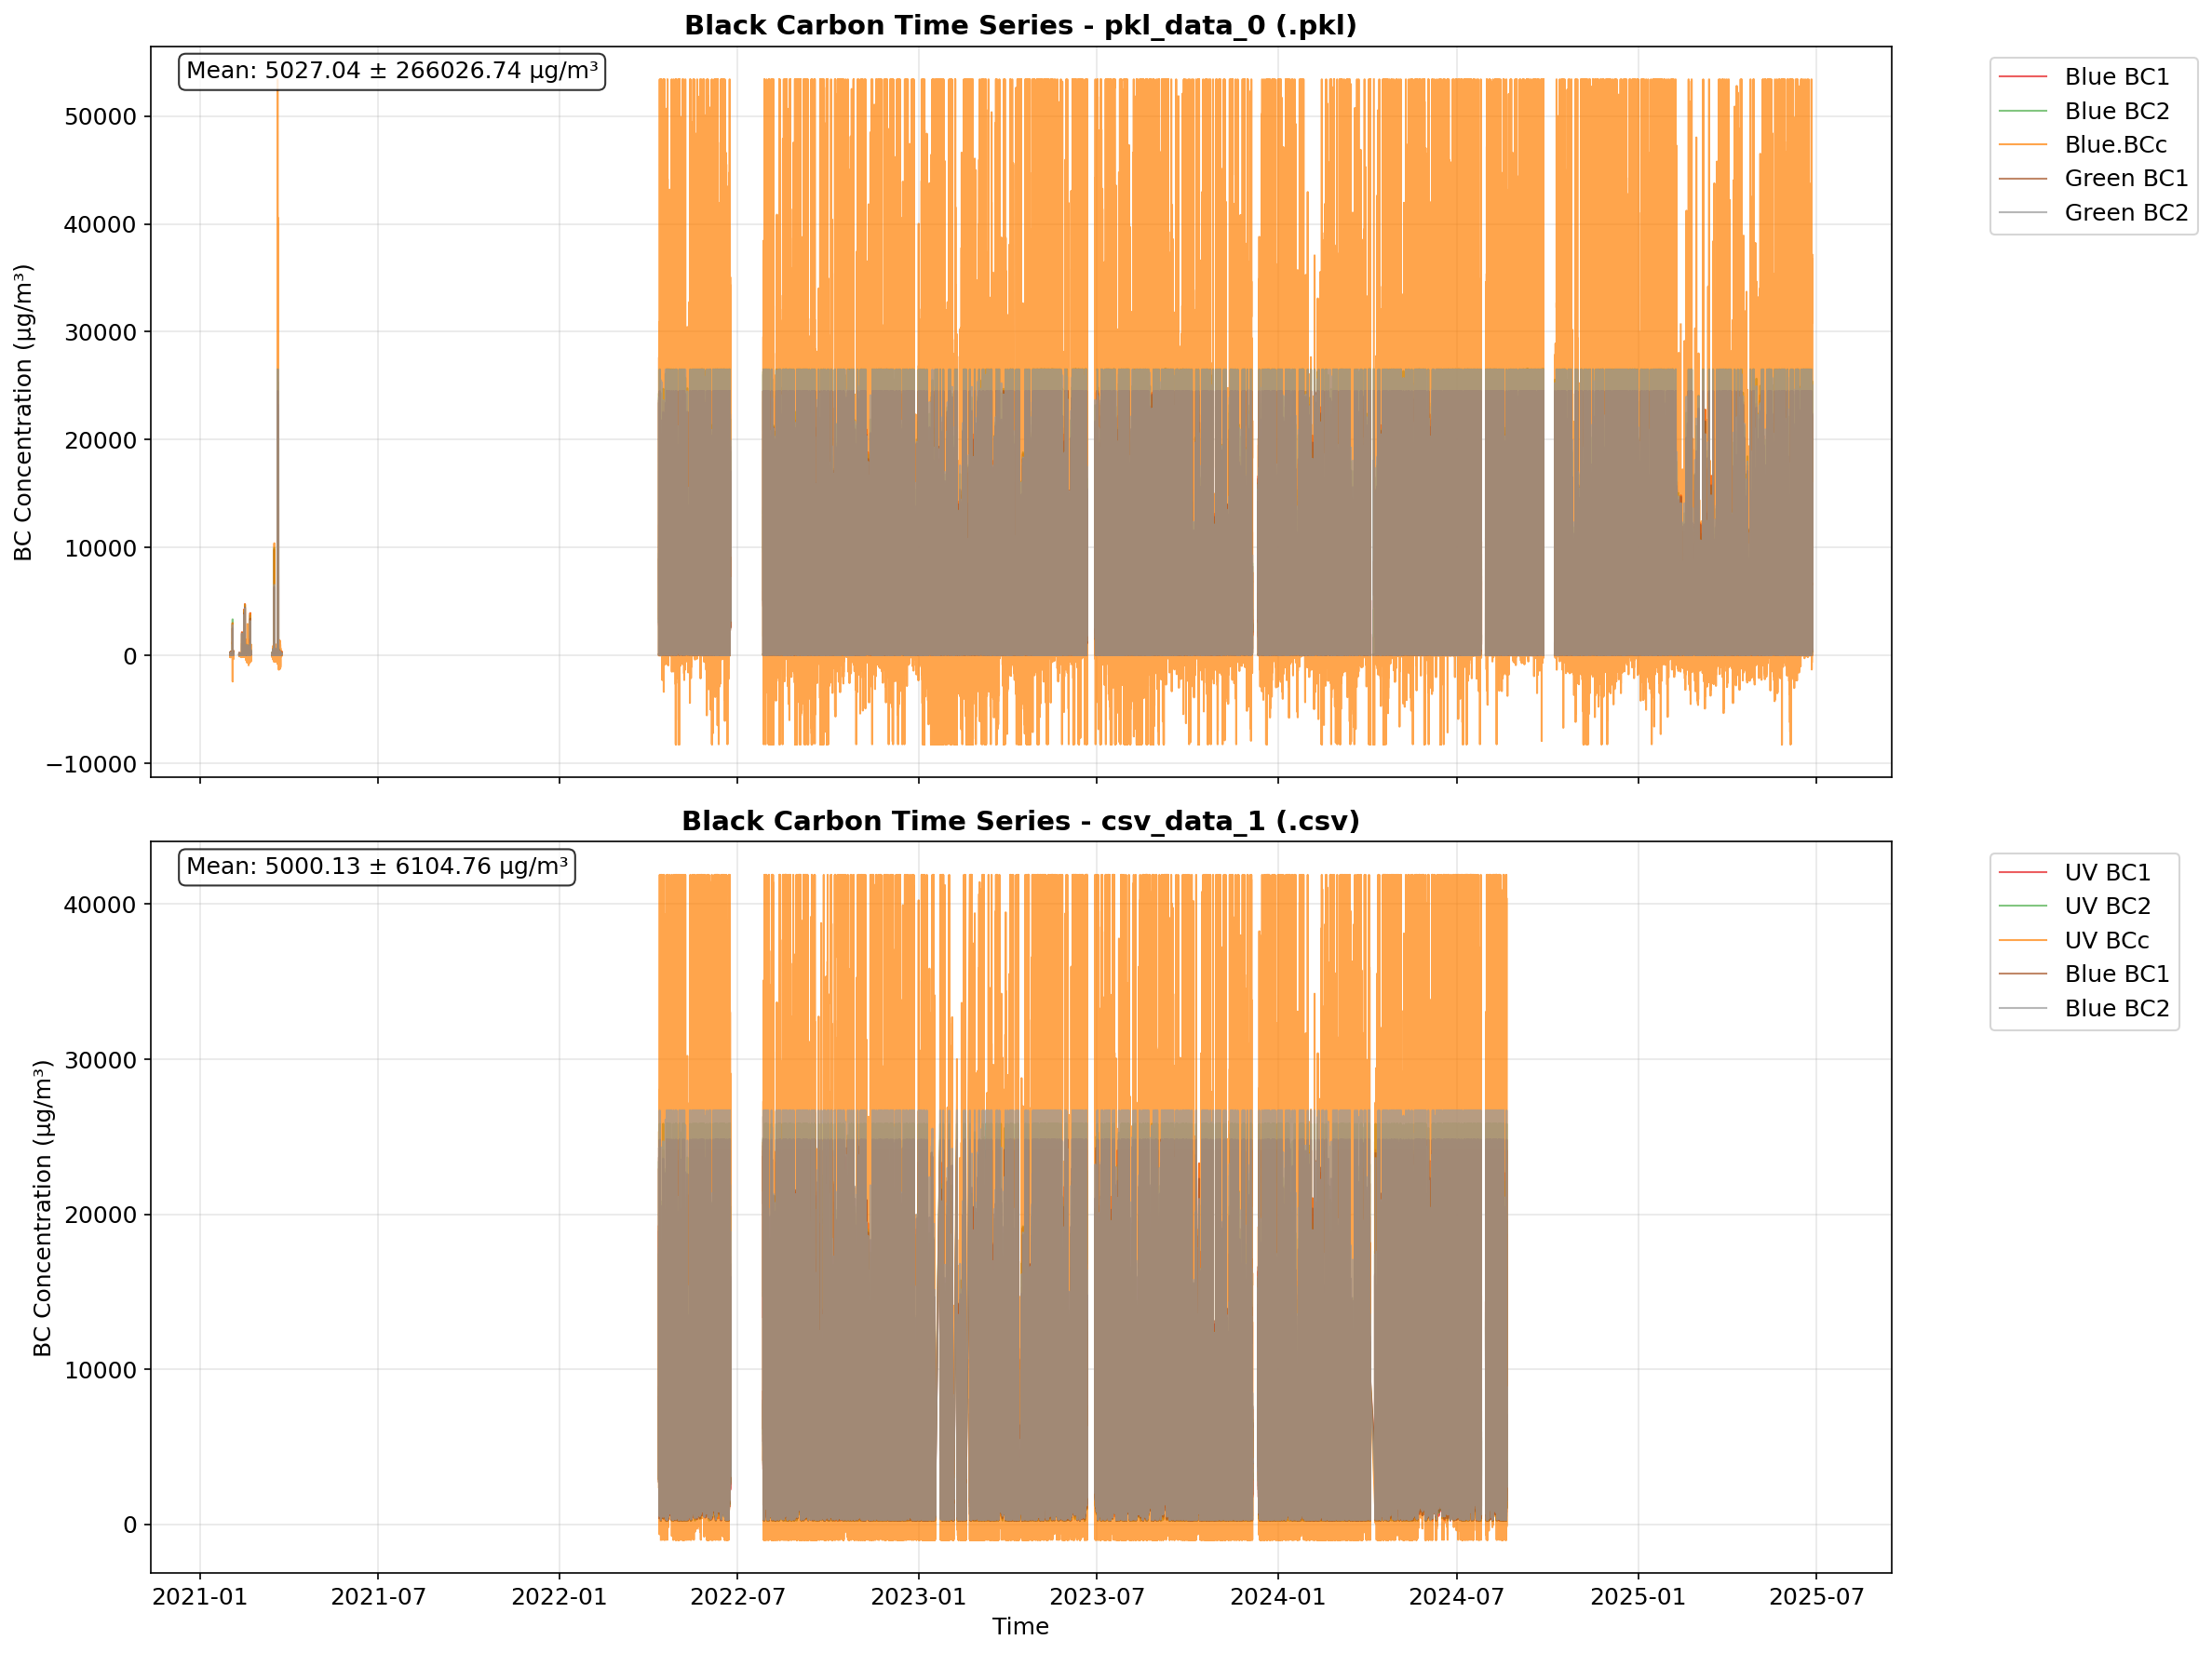


📊 Creating distribution comparison plots...


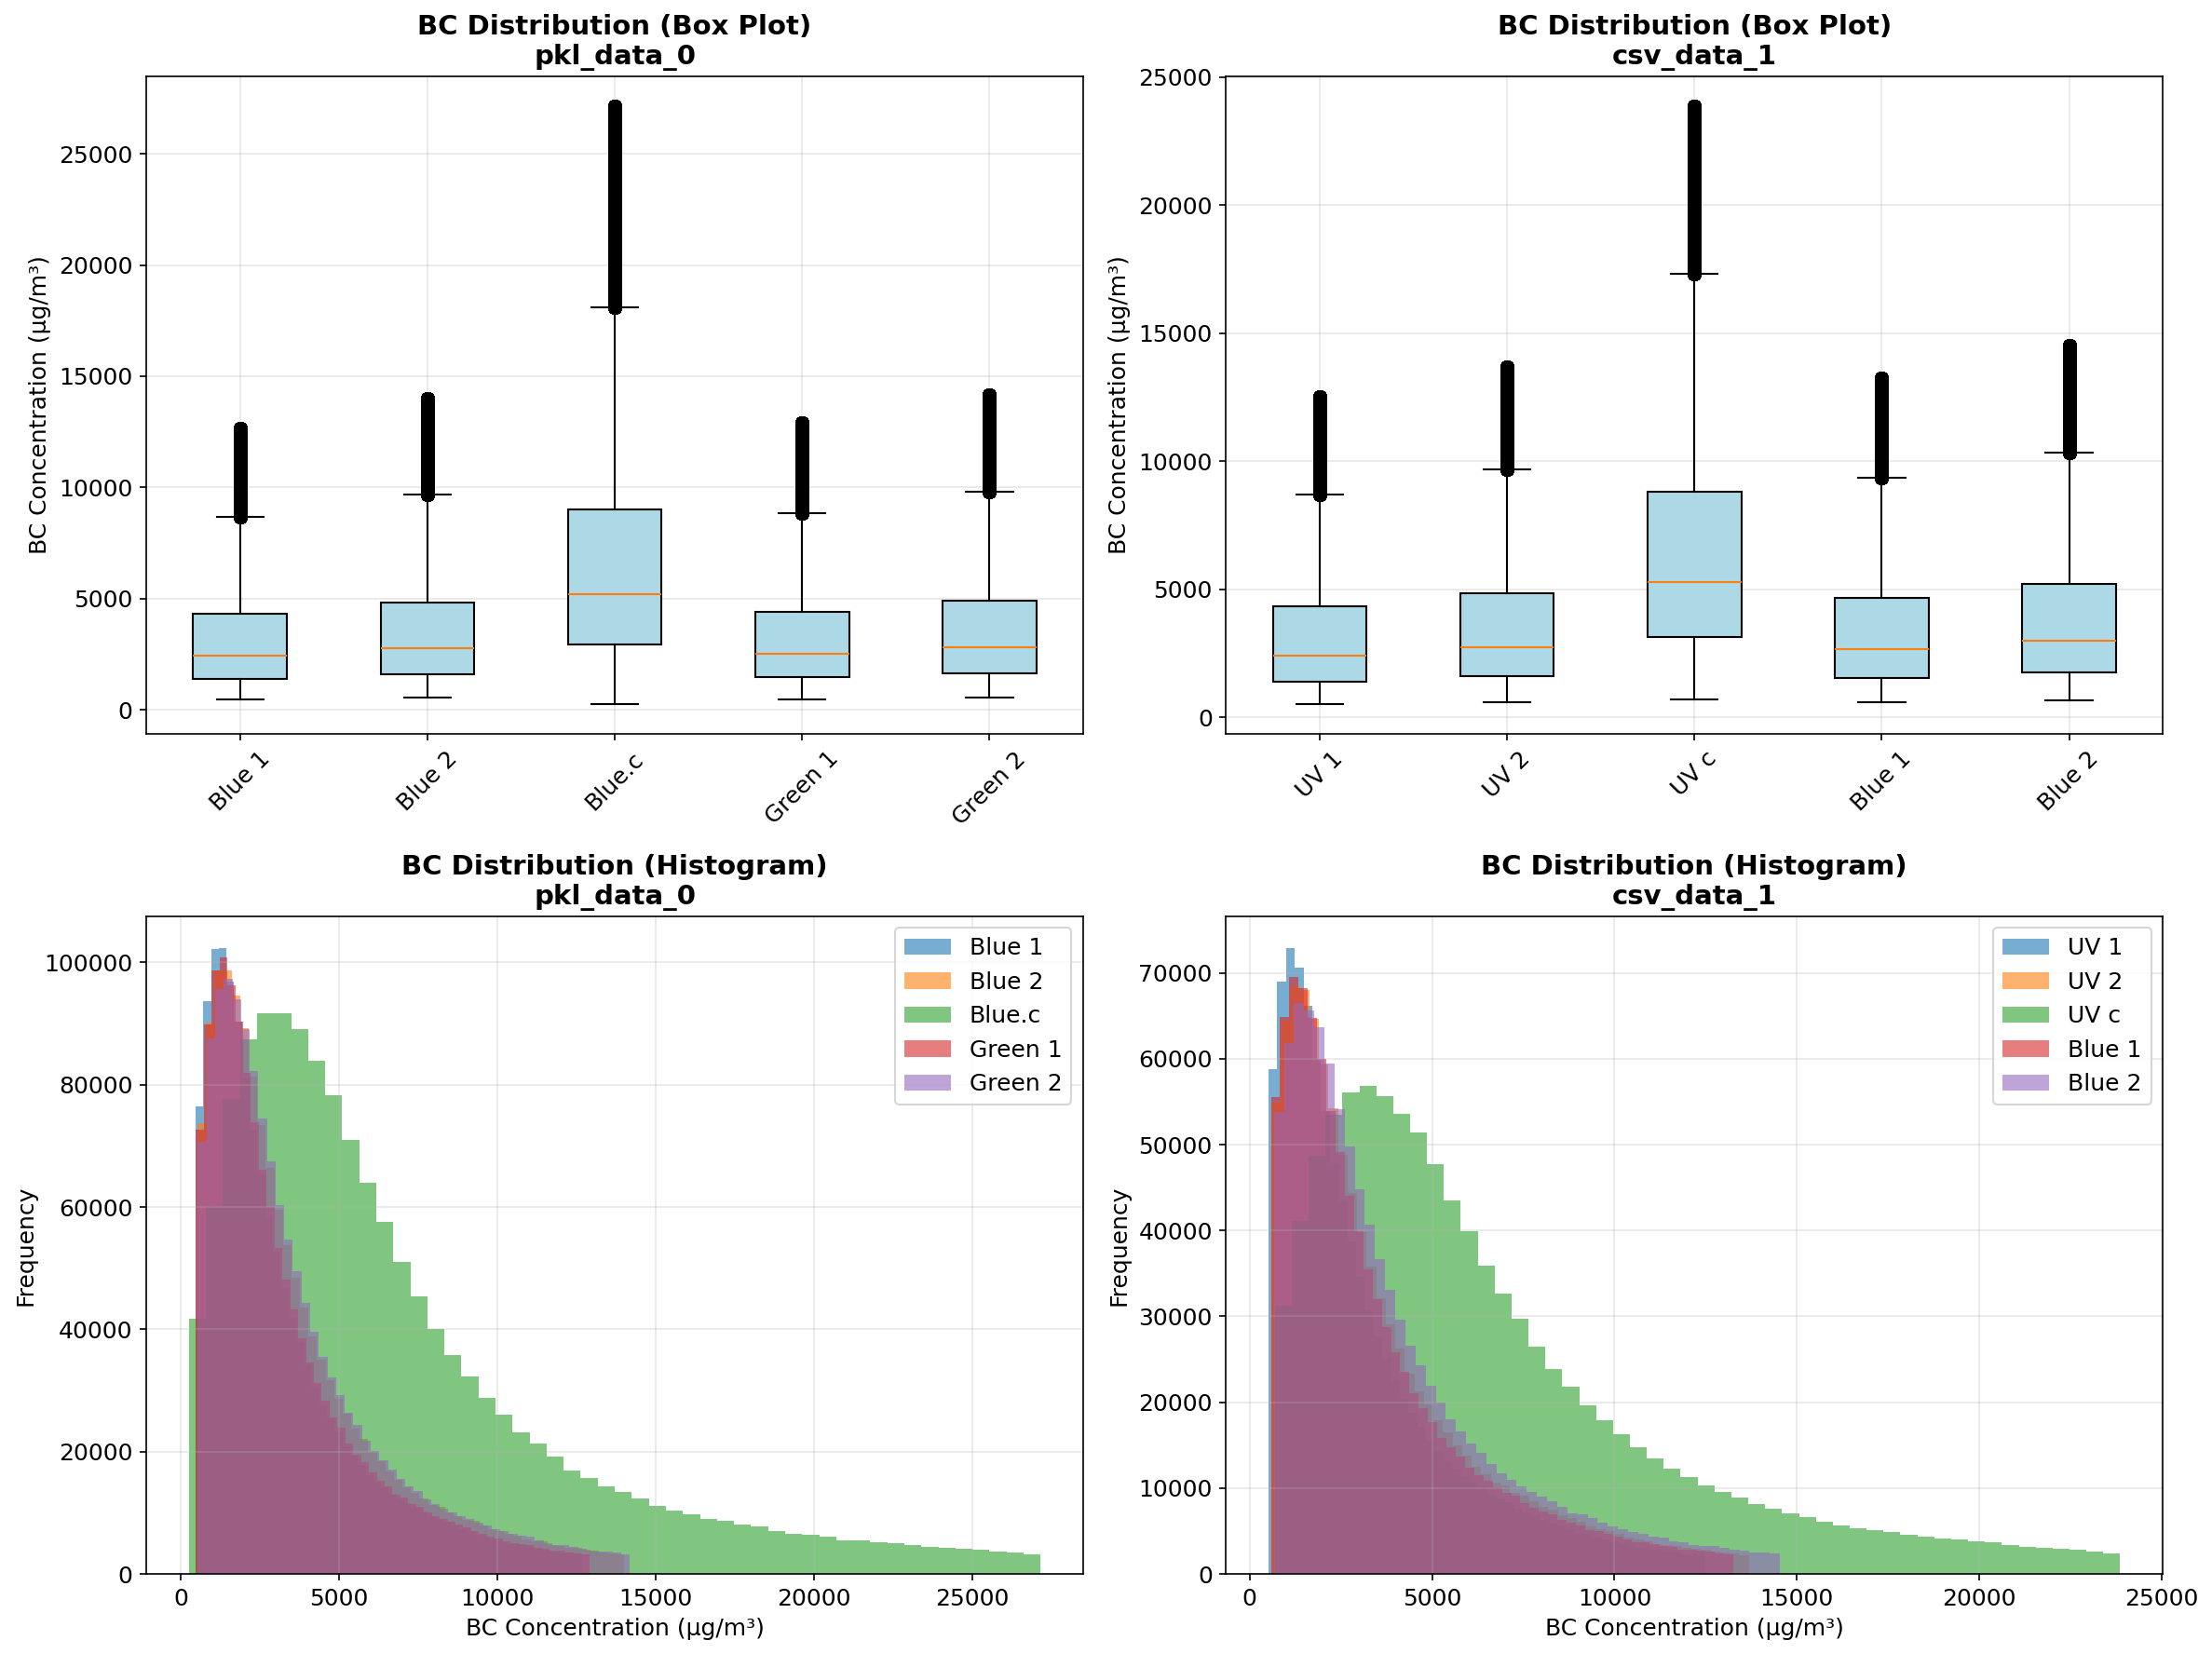


📋 Creating comprehensive data summary comparison...
📊 COMPREHENSIVE DATA COMPARISON
📋 Dataset Comparison Table:


,Dataset,File_Type,Total_Rows,Total_Columns,BC_Channels,ATN_Channels,Memory_MB,Missing_Data_%,BC_Mean,BC_Std,BC_Min,BC_Max,BC_Median
0,pkl_data_0,.pkl,1665156,239,30,25,7443.05,45.16,5442.07,644499.75,-1.490630e+09,791578432.0,3333.0
1,csv_data_1,.csv,1095086,77,15,10,940.18,1.30,5806.70,82399.47,-2.343295e+08,216328672.0,3629.0


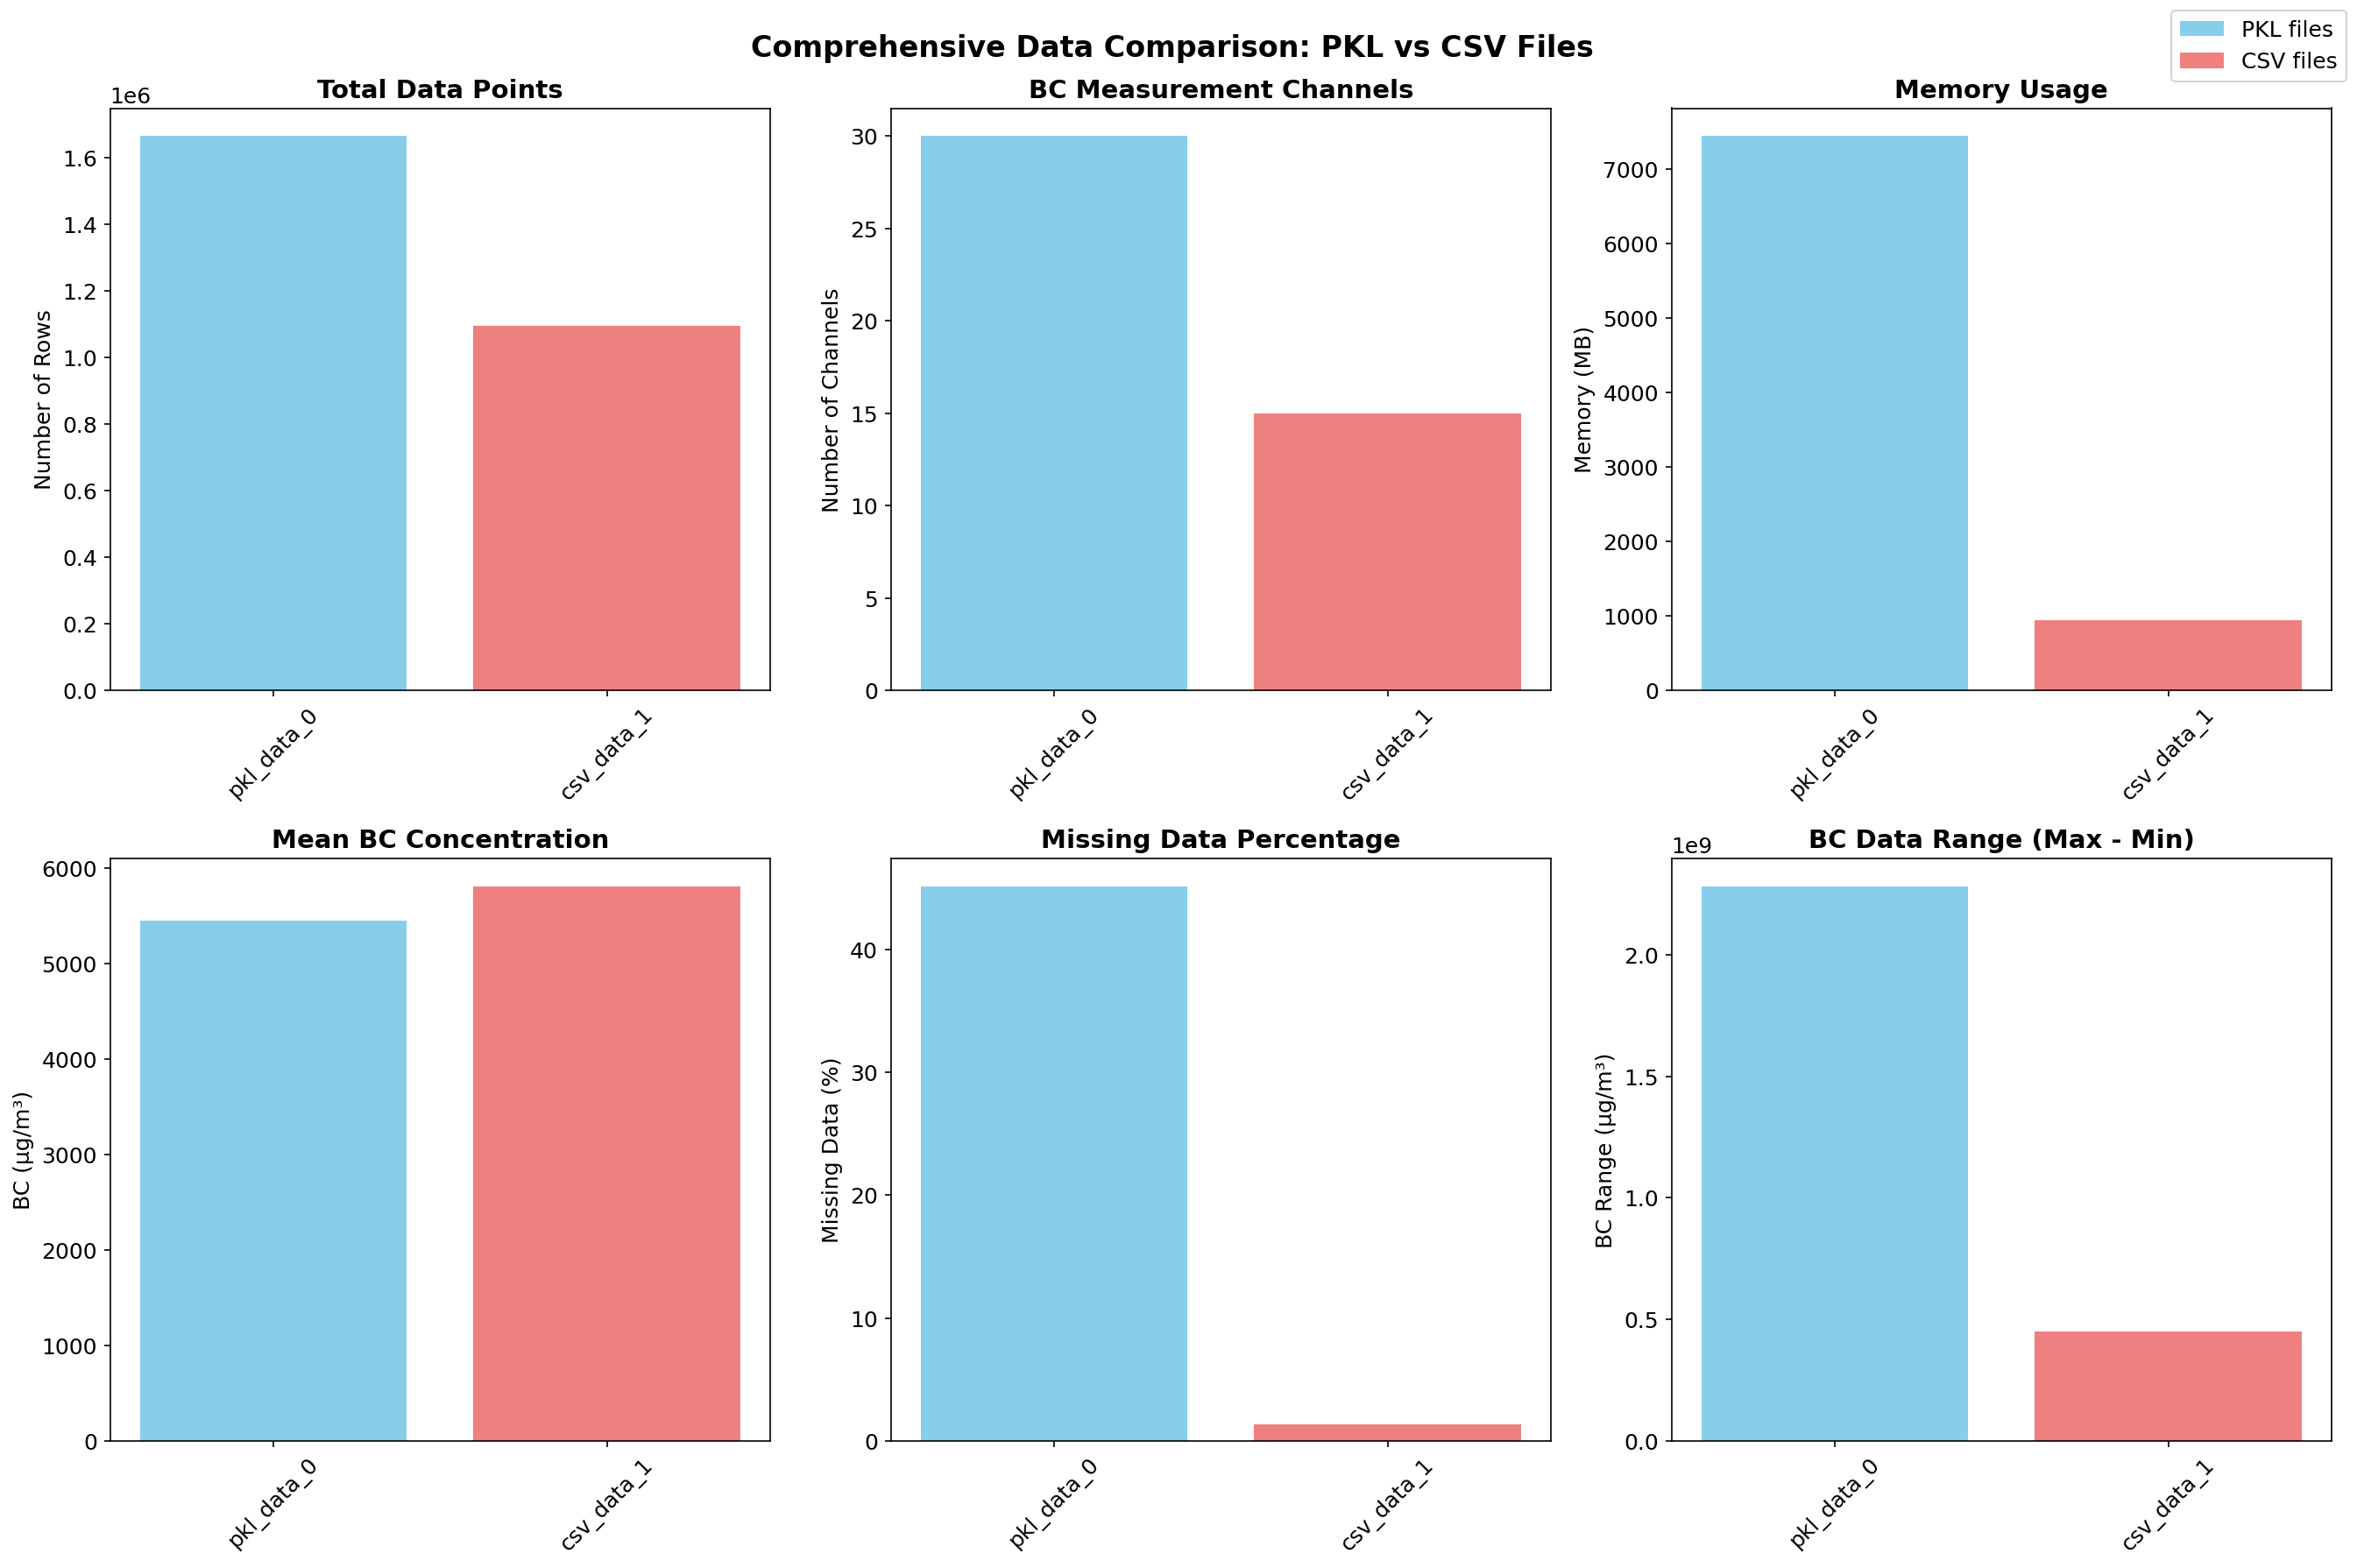

In [5]:
# Run the improved visualizations with our loaded data
print("📈 Creating improved time series plots...")
plot_improved_time_series(datasets, summaries)

print("\n📊 Creating distribution comparison plots...")
plot_bc_distribution_comparison(datasets, summaries)

print("\n📋 Creating comprehensive data summary comparison...")
create_data_summary_comparison(datasets, summaries)

🔗 Creating correlation analysis...


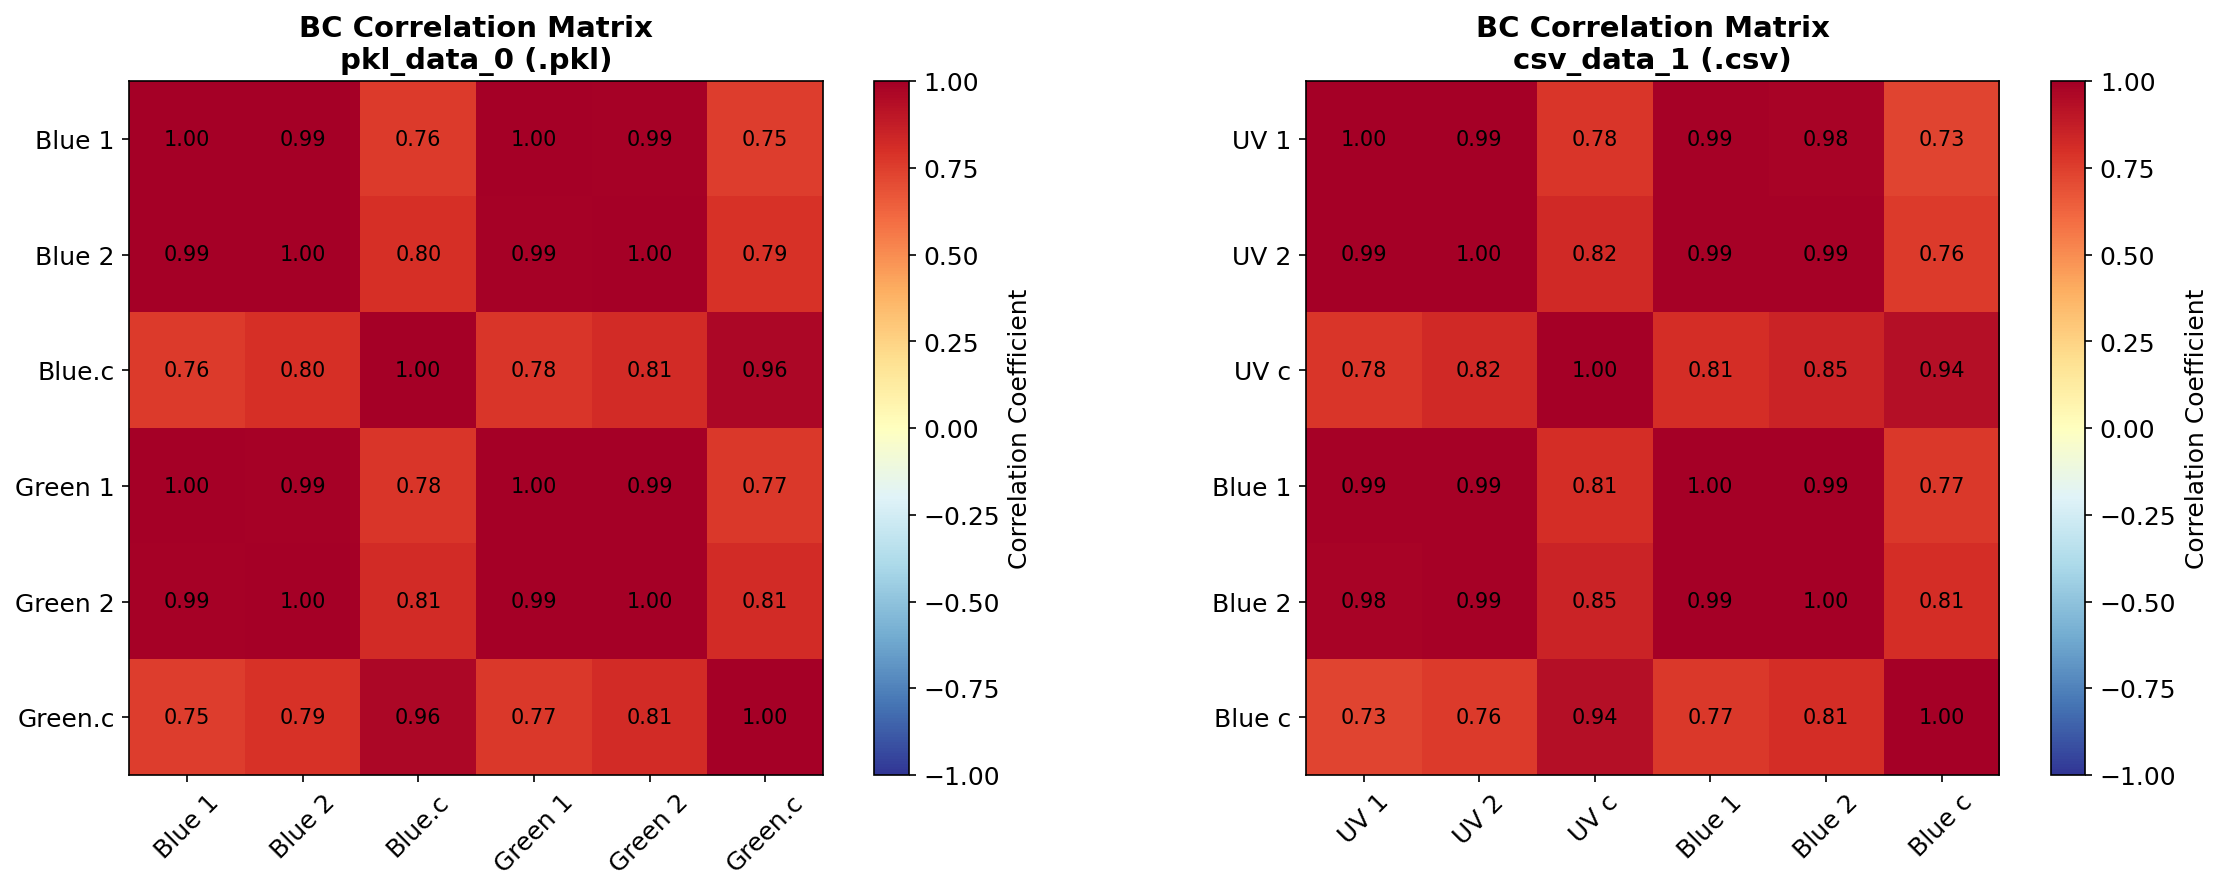


🔍 Performing data quality assessment...
🔍 DATA QUALITY ASSESSMENT

📊 PKL_DATA_0 QUALITY REPORT:
   File Type: .pkl
   Data Points: 1,665,156
   Missing Data: 45.16%
   Valid BC Data: 47.88%
   Negative BC Values: 4.23%
   Extreme BC Values: 0.13%
   Quality Score: 46.2/100

📊 CSV_DATA_1 QUALITY REPORT:
   File Type: .csv
   Data Points: 1,095,086
   Missing Data: 1.30%
   Valid BC Data: 99.97%
   Negative BC Values: 0.78%
   Extreme BC Values: 0.00%
   Quality Score: 97.1/100

📋 Quality Comparison Table:


,Dataset,File_Type,Total_Data_Points,Missing_Data_%,Valid_BC_Data_%,Negative_BC_%,Extreme_BC_%,Overall_Quality_Score
0,pkl_data_0,.pkl,1665156,45.16,47.88,4.23,0.13,46.25
1,csv_data_1,.csv,1095086,1.30,99.97,0.78,0.00,97.13


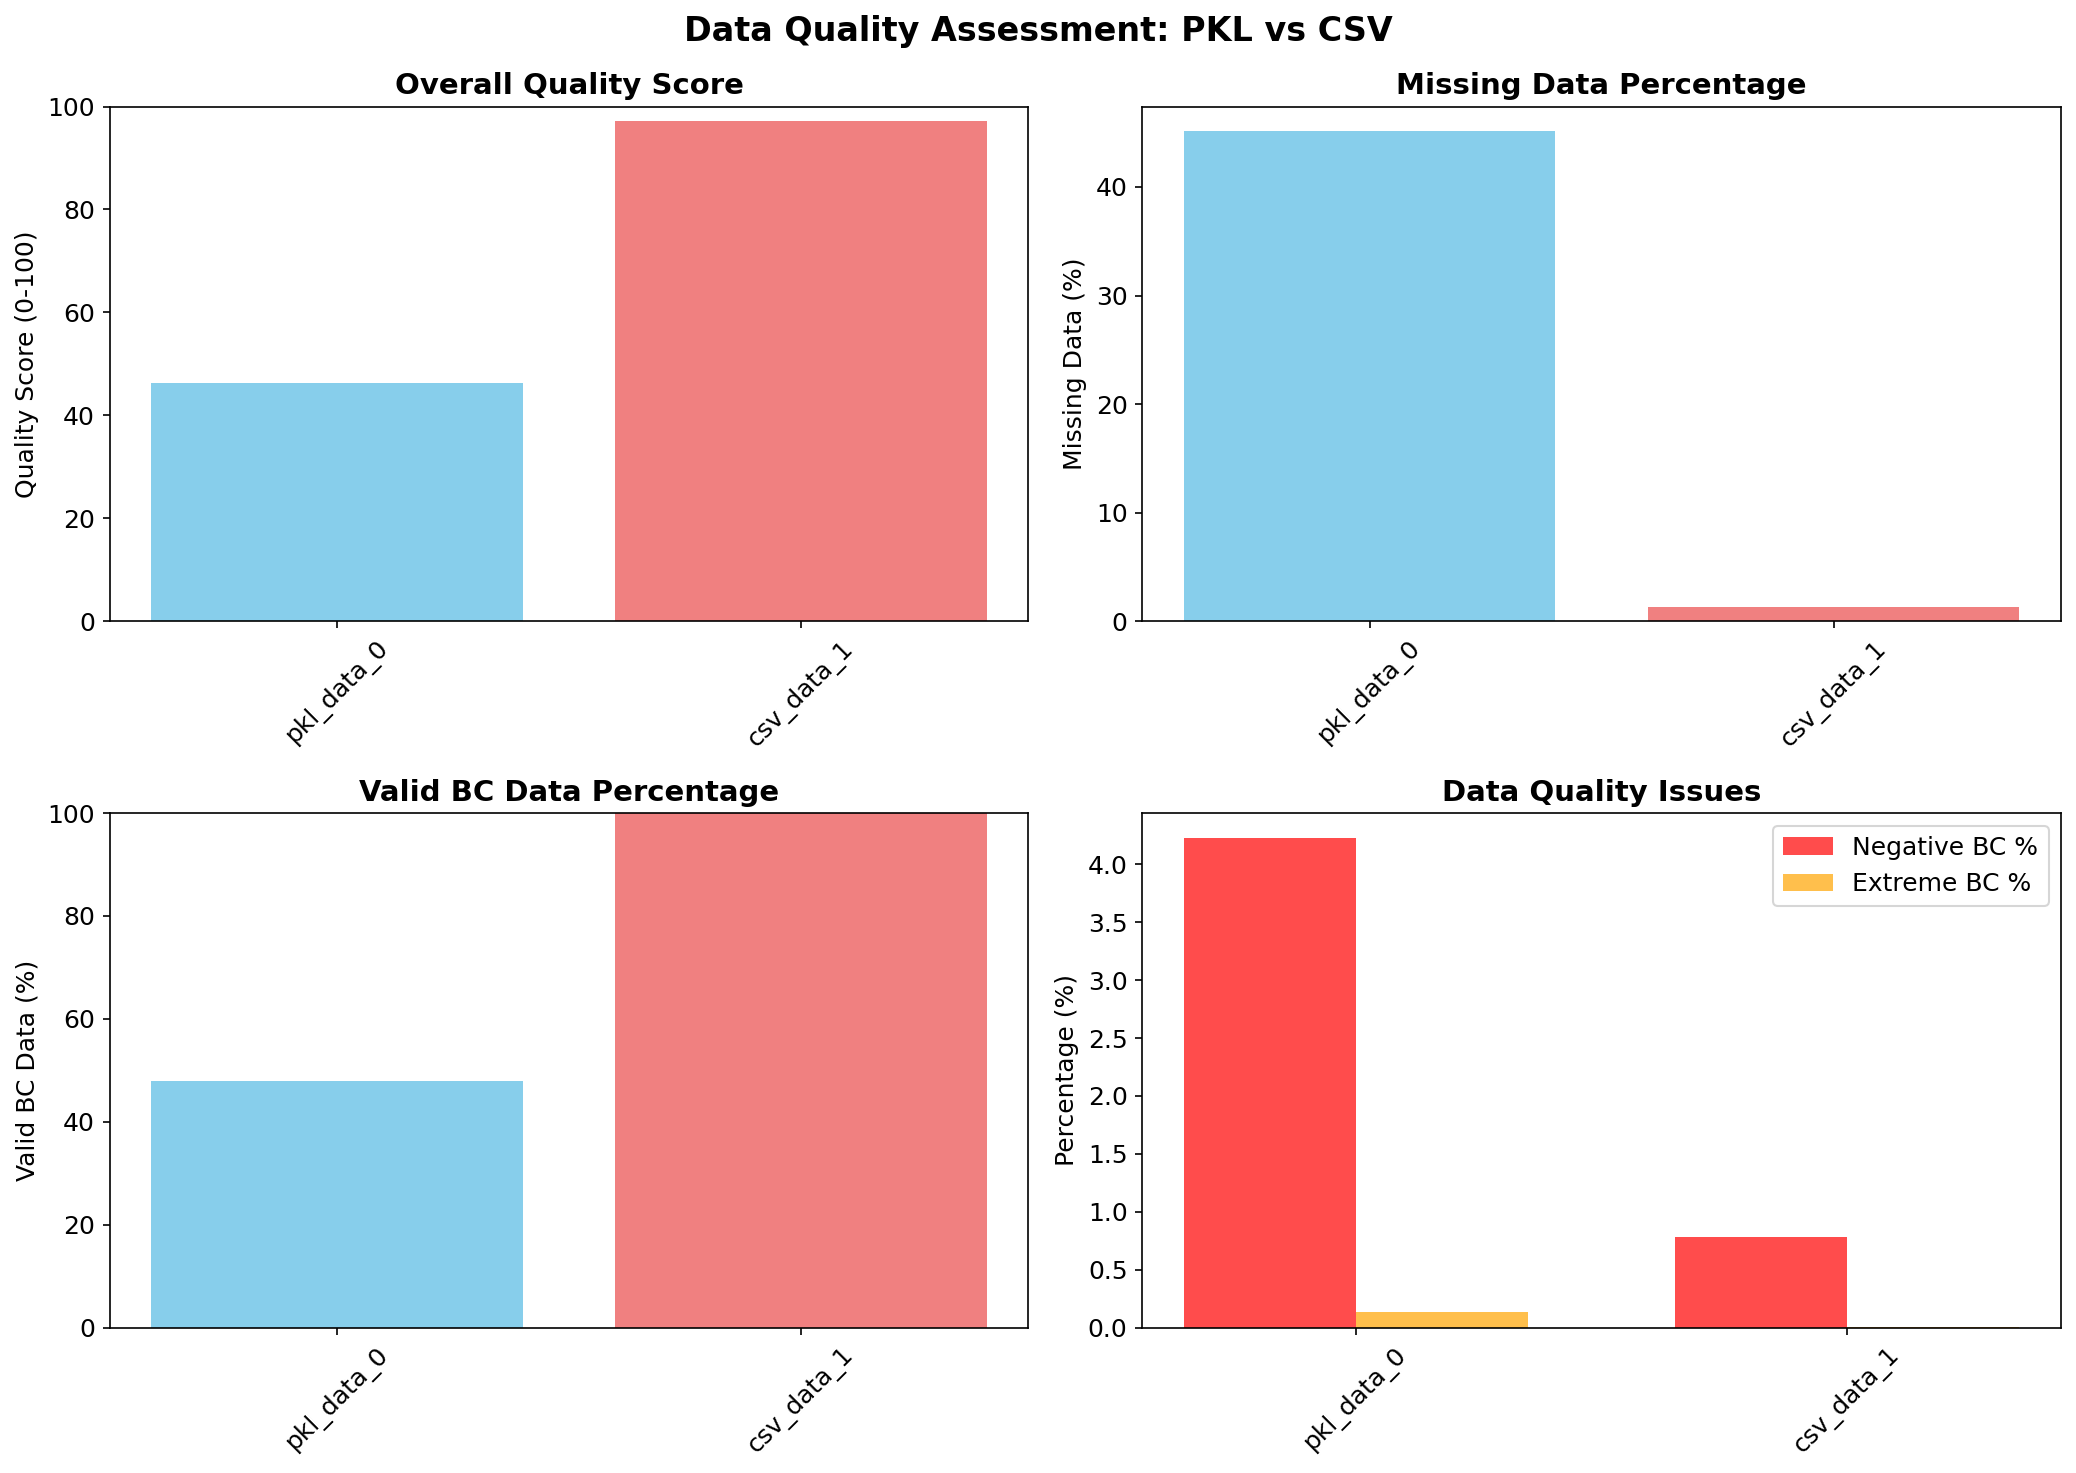

In [6]:
def create_correlation_analysis(datasets, summaries):
    """
    Create correlation analysis between BC measurements
    """
    
    fig, axes = plt.subplots(1, len(datasets), figsize=(8*len(datasets), 6))
    
    if len(datasets) == 1:
        axes = [axes]
    
    for idx, (dataset_name, df) in enumerate(datasets.items()):
        summary = summaries[dataset_name]
        bc_cols = summary['bc_columns'][:6]  # Use first 6 BC columns for correlation
        
        if len(bc_cols) > 1:
            # Get data for correlation, removing extreme outliers
            corr_data = []
            valid_cols = []
            
            for col in bc_cols:
                if col in df.columns:
                    data = df[col].dropna()
                    if len(data) > 1000:  # Ensure we have enough data points
                        # Remove extreme outliers for better correlation analysis
                        q95 = data.quantile(0.95)
                        q05 = data.quantile(0.05)
                        filtered_data = data[(data >= q05) & (data <= q95)]
                        if len(filtered_data) > 500:
                            corr_data.append(filtered_data)
                            valid_cols.append(col.replace('BC', '').replace('.BCc', ''))
            
            if len(corr_data) > 1:
                # Create correlation matrix
                corr_df = pd.DataFrame({col: data for col, data in zip(valid_cols, corr_data)})
                corr_matrix = corr_df.corr()
                
                # Create heatmap
                im = axes[idx].imshow(corr_matrix.values, cmap='RdYlBu_r', vmin=-1, vmax=1)
                
                # Add correlation values as text
                for i in range(len(corr_matrix)):
                    for j in range(len(corr_matrix)):
                        text = axes[idx].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                                           ha="center", va="center", color="black", fontsize=10)
                
                axes[idx].set_xticks(range(len(valid_cols)))
                axes[idx].set_yticks(range(len(valid_cols)))
                axes[idx].set_xticklabels(valid_cols, rotation=45)
                axes[idx].set_yticklabels(valid_cols)
                axes[idx].set_title(f'BC Correlation Matrix\n{dataset_name} ({summary["file_type"]})',
                                  fontweight='bold')
                
                # Add colorbar
                plt.colorbar(im, ax=axes[idx], label='Correlation Coefficient')
            else:
                axes[idx].text(0.5, 0.5, 'Insufficient valid BC data\nfor correlation analysis',
                             ha='center', va='center', transform=axes[idx].transAxes,
                             fontsize=12)
                axes[idx].set_title(f'{dataset_name} ({summary["file_type"]})')
        else:
            axes[idx].text(0.5, 0.5, 'Insufficient BC columns\nfor correlation analysis',
                         ha='center', va='center', transform=axes[idx].transAxes,
                         fontsize=12)
            axes[idx].set_title(f'{dataset_name} ({summary["file_type"]})')
    
    plt.tight_layout()
    plt.show()

def create_data_quality_summary(datasets, summaries):
    """
    Create data quality assessment summary
    """
    
    print("🔍 DATA QUALITY ASSESSMENT")
    print("=" * 80)
    
    quality_data = []
    
    for dataset_name, df in datasets.items():
        summary = summaries[dataset_name]
        
        # Basic quality metrics
        total_cells = df.size
        missing_cells = df.isnull().sum().sum()
        missing_pct = (missing_cells / total_cells) * 100
        
        # BC-specific quality metrics
        bc_cols = summary['bc_columns']
        bc_quality = {}
        
        if bc_cols:
            bc_data_quality = []
            for col in bc_cols:
                if col in df.columns:
                    col_data = df[col].dropna()
                    if len(col_data) > 0:
                        # Check for negative values (unusual for BC)
                        negative_pct = (col_data < 0).sum() / len(col_data) * 100
                        
                        # Check for extreme values
                        q99 = col_data.quantile(0.99)
                        extreme_pct = (col_data > q99 * 5).sum() / len(col_data) * 100
                        
                        bc_data_quality.append({
                            'column': col,
                            'valid_data_pct': len(col_data) / len(df) * 100,
                            'negative_pct': negative_pct,
                            'extreme_pct': extreme_pct
                        })
            
            if bc_data_quality:
                avg_valid = np.mean([q['valid_data_pct'] for q in bc_data_quality])
                avg_negative = np.mean([q['negative_pct'] for q in bc_data_quality])
                avg_extreme = np.mean([q['extreme_pct'] for q in bc_data_quality])
                
                bc_quality = {
                    'avg_valid_data_pct': avg_valid,
                    'avg_negative_pct': avg_negative,
                    'avg_extreme_pct': avg_extreme
                }
        
        # Overall quality score (0-100)
        quality_score = 100
        quality_score -= missing_pct  # Penalize missing data
        if bc_quality:
            quality_score -= bc_quality['avg_negative_pct'] * 2  # Penalize negative values more
            quality_score -= bc_quality['avg_extreme_pct']  # Penalize extreme values
        quality_score = max(0, quality_score)
        
        quality_data.append({
            'Dataset': dataset_name,
            'File_Type': summary['file_type'],
            'Total_Data_Points': len(df),
            'Missing_Data_%': missing_pct,
            'Valid_BC_Data_%': bc_quality.get('avg_valid_data_pct', 0),
            'Negative_BC_%': bc_quality.get('avg_negative_pct', 0),
            'Extreme_BC_%': bc_quality.get('avg_extreme_pct', 0),
            'Overall_Quality_Score': quality_score
        })
        
        print(f"\n📊 {dataset_name.upper()} QUALITY REPORT:")
        print(f"   File Type: {summary['file_type']}")
        print(f"   Data Points: {len(df):,}")
        print(f"   Missing Data: {missing_pct:.2f}%")
        if bc_quality:
            print(f"   Valid BC Data: {bc_quality['avg_valid_data_pct']:.2f}%")
            print(f"   Negative BC Values: {bc_quality['avg_negative_pct']:.2f}%")
            print(f"   Extreme BC Values: {bc_quality['avg_extreme_pct']:.2f}%")
        print(f"   Quality Score: {quality_score:.1f}/100")
    
    # Create quality comparison visualization
    if len(quality_data) > 1:
        quality_df = pd.DataFrame(quality_data)
        
        print(f"\n📋 Quality Comparison Table:")
        display(quality_df.round(2))
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Quality score comparison
        colors = ['skyblue' if '.pkl' in ft else 'lightcoral' for ft in quality_df['File_Type']]
        
        axes[0, 0].bar(quality_df['Dataset'], quality_df['Overall_Quality_Score'], color=colors)
        axes[0, 0].set_title('Overall Quality Score', fontweight='bold')
        axes[0, 0].set_ylabel('Quality Score (0-100)')
        axes[0, 0].set_ylim(0, 100)
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Missing data comparison
        axes[0, 1].bar(quality_df['Dataset'], quality_df['Missing_Data_%'], color=colors)
        axes[0, 1].set_title('Missing Data Percentage', fontweight='bold')
        axes[0, 1].set_ylabel('Missing Data (%)')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Valid BC data comparison
        axes[1, 0].bar(quality_df['Dataset'], quality_df['Valid_BC_Data_%'], color=colors)
        axes[1, 0].set_title('Valid BC Data Percentage', fontweight='bold')
        axes[1, 0].set_ylabel('Valid BC Data (%)')
        axes[1, 0].set_ylim(0, 100)
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Data issues comparison
        x = range(len(quality_df))
        width = 0.35
        axes[1, 1].bar([i - width/2 for i in x], quality_df['Negative_BC_%'], 
                      width, label='Negative BC %', color='red', alpha=0.7)
        axes[1, 1].bar([i + width/2 for i in x], quality_df['Extreme_BC_%'], 
                      width, label='Extreme BC %', color='orange', alpha=0.7)
        axes[1, 1].set_title('Data Quality Issues', fontweight='bold')
        axes[1, 1].set_ylabel('Percentage (%)')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels(quality_df['Dataset'], rotation=45)
        axes[1, 1].legend()
        
        plt.suptitle('Data Quality Assessment: PKL vs CSV', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Run additional analysis
print("🔗 Creating correlation analysis...")
create_correlation_analysis(datasets, summaries)

print("\n🔍 Performing data quality assessment...")
create_data_quality_summary(datasets, summaries)

## 5. Interactive Plotly Visualizations

Let's create interactive plots using Plotly for better data exploration.

In [6]:
def create_interactive_timeseries(datasets, summaries):
    """
    Create interactive time series plots using Plotly
    """
    
    # Create subplots for each dataset
    fig = make_subplots(
        rows=len(datasets), cols=1,
        subplot_titles=[f"{name} ({summaries[name]['file_type']})" for name in datasets.keys()],
        shared_xaxes=True,
        vertical_spacing=0.05
    )
    
    colors = px.colors.qualitative.Set1
    
    for row_idx, (dataset_name, df) in enumerate(datasets.items(), 1):
        summary = summaries[dataset_name]
        bc_cols = summary['bc_columns'][:5]  # Limit to 5 columns for clarity
        
        for col_idx, col in enumerate(bc_cols):
            if col in df.columns:
                fig.add_trace(
                    go.Scatter(
                        x=df.index,
                        y=df[col],
                        name=f"{dataset_name}_{col}",
                        line=dict(color=colors[col_idx % len(colors)]),
                        opacity=0.7
                    ),
                    row=row_idx, col=1
                )
    
    fig.update_layout(
        height=300 * len(datasets),
        title_text="Interactive Black Carbon Time Series Analysis",
        title_font_size=16,
        showlegend=True
    )
    
    fig.update_yaxes(title_text="BC Concentration (µg/m³)")
    fig.update_xaxes(title_text="Time", row=len(datasets), col=1)
    
    return fig

def create_correlation_heatmap(datasets, summaries):
    """
    Create correlation heatmaps for BC measurements
    """
    
    fig, axes = plt.subplots(1, len(datasets), figsize=(8*len(datasets), 6))
    
    if len(datasets) == 1:
        axes = [axes]
    
    for idx, (dataset_name, df) in enumerate(datasets.items()):
        summary = summaries[dataset_name]
        bc_cols = summary['bc_columns']
        
        if len(bc_cols) > 1:
            # Calculate correlation matrix
            corr_matrix = df[bc_cols].corr()
            
            # Create heatmap
            sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0,
                       square=True, ax=axes[idx], fmt='.2f',
                       cbar_kws={'label': 'Correlation Coefficient'})
            
            axes[idx].set_title(f'BC Correlation Matrix\n{dataset_name} ({summary["file_type"]})',
                              fontweight='bold')
        else:
            axes[idx].text(0.5, 0.5, 'Insufficient BC columns\nfor correlation analysis',
                         ha='center', va='center', transform=axes[idx].transAxes,
                         fontsize=12)
            axes[idx].set_title(f'{dataset_name} ({summary["file_type"]})')
    
    plt.tight_layout()
    plt.show()

def create_distribution_plots(datasets, summaries):
    """
    Create distribution plots for BC measurements
    """
    
    fig, axes = plt.subplots(2, len(datasets), figsize=(6*len(datasets), 10))
    
    if len(datasets) == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, (dataset_name, df) in enumerate(datasets.items()):
        summary = summaries[dataset_name]
        bc_cols = summary['bc_columns'][:3]  # Use first 3 BC columns
        
        # Box plot
        if bc_cols:
            df[bc_cols].boxplot(ax=axes[0, idx])
            axes[0, idx].set_title(f'BC Distribution (Box Plot)\n{dataset_name}', fontweight='bold')
            axes[0, idx].set_ylabel('BC Concentration (µg/m³)')
            axes[0, idx].tick_params(axis='x', rotation=45)
            
            # Histogram
            for col in bc_cols:
                axes[1, idx].hist(df[col].dropna(), alpha=0.6, bins=30, label=col)
            
            axes[1, idx].set_title(f'BC Distribution (Histogram)\n{dataset_name}', fontweight='bold')
            axes[1, idx].set_xlabel('BC Concentration (µg/m³)')
            axes[1, idx].set_ylabel('Frequency')
            axes[1, idx].legend()
        else:
            for row in [0, 1]:
                axes[row, idx].text(0.5, 0.5, 'No BC columns available',
                                  ha='center', va='center', transform=axes[row, idx].transAxes)
    
    plt.tight_layout()
    plt.show()

# Create interactive visualizations
print("🎯 Creating interactive time series plots...")
interactive_fig = create_interactive_timeseries(datasets, summaries)
interactive_fig.show()

print("🔗 Creating correlation analysis...")
create_correlation_heatmap(datasets, summaries)

print("📊 Creating distribution plots...")
create_distribution_plots(datasets, summaries)

🎯 Creating interactive time series plots...


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## 6. Advanced Analysis and Source Apportionment

Let's perform more advanced analysis using the aethmodular system's built-in analyzers.

In [ ]:
def perform_black_carbon_analysis(datasets, summaries):
    """
    Perform comprehensive Black Carbon analysis using the modular system
    """
    
    analysis_results = {}
    
    for dataset_name, df in datasets.items():
        print(f"\n🔬 Analyzing {dataset_name}...")
        print("-" * 50)
        
        summary = summaries[dataset_name]
        
        try:
            # Initialize the Black Carbon Analyzer
            bc_analyzer = BlackCarbonAnalyzer()
            
            # Perform analysis
            results = bc_analyzer.analyze(
                df, 
                time_resolution='hourly',
                include_trends=True
            )
            
            analysis_results[dataset_name] = results
            
            # Display key results
            print(f"📊 Basic Statistics for {dataset_name}:")
            if 'basic_statistics' in results:
                for bc_type, stats in results['basic_statistics'].items():
                    if isinstance(stats, dict) and 'mean' in stats:
                        print(f"   {bc_type}: {stats['mean']:.3f} ± {stats['std']:.3f} µg/m³")
            
            # Display temporal trends if available
            if 'temporal_analysis' in results:
                print(f"\n📈 Temporal Trends:")
                temporal = results['temporal_analysis']
                if 'hourly_pattern' in temporal:
                    hourly_data = temporal['hourly_pattern']
                    peak_hour = hourly_data.idxmax() if hasattr(hourly_data, 'idxmax') else 'N/A'
                    min_hour = hourly_data.idxmin() if hasattr(hourly_data, 'idxmin') else 'N/A'
                    print(f"   Peak hour: {peak_hour}")
                    print(f"   Minimum hour: {min_hour}")
            
        except Exception as e:
            print(f"⚠️ Analysis failed for {dataset_name}: {e}")
            analysis_results[dataset_name] = None
    
    return analysis_results

def plot_diurnal_patterns(datasets, summaries, analysis_results):
    """
    Plot diurnal patterns for BC measurements
    """
    
    fig, axes = plt.subplots(1, len(datasets), figsize=(8*len(datasets), 6))
    
    if len(datasets) == 1:
        axes = [axes]
    
    for idx, (dataset_name, df) in enumerate(datasets.items()):
        summary = summaries[dataset_name]
        bc_cols = summary['bc_columns'][:3]  # Use first 3 BC columns
        
        if bc_cols:
            # Calculate hourly averages
            df_hourly = df.groupby(df.index.hour)[bc_cols].mean()
            
            # Plot diurnal pattern
            for col in bc_cols:
                axes[idx].plot(df_hourly.index, df_hourly[col], 
                             marker='o', linewidth=2, label=col)
            
            axes[idx].set_title(f'Diurnal Pattern\n{dataset_name} ({summary["file_type"]})',
                              fontweight='bold')
            axes[idx].set_xlabel('Hour of Day')
            axes[idx].set_ylabel('BC Concentration (µg/m³)')
            axes[idx].set_xticks(range(0, 24, 3))
            axes[idx].grid(True, alpha=0.3)
            axes[idx].legend()
        else:
            axes[idx].text(0.5, 0.5, 'No BC columns available',
                         ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(f'{dataset_name} ({summary["file_type"]})')
    
    plt.tight_layout()
    plt.show()

def create_comparison_dashboard(datasets, summaries):
    """
    Create a comprehensive comparison dashboard
    """
    
    # Prepare data for comparison
    comparison_data = []
    
    for dataset_name, df in datasets.items():
        summary = summaries[dataset_name]
        bc_cols = summary['bc_columns']
        
        if bc_cols:
            # Calculate key metrics
            bc_data = df[bc_cols].mean(axis=1)  # Average across wavelengths
            
            comparison_data.append({
                'Dataset': dataset_name,
                'File_Type': summary['file_type'],
                'Mean_BC': bc_data.mean(),
                'Std_BC': bc_data.std(),
                'Max_BC': bc_data.max(),
                'Min_BC': bc_data.min(),
                'Data_Points': len(bc_data),
                'BC_Columns': len(bc_cols)
            })
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(comparison_data)
    
    if not comparison_df.empty:
        print("📊 Dataset Comparison Summary:")
        print("=" * 80)
        display(comparison_df.round(3))
        
        # Create comparison plots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Bar plot of mean BC concentrations
        axes[0, 0].bar(comparison_df['Dataset'], comparison_df['Mean_BC'], 
                      color=['skyblue' if '.pkl' in ft else 'lightcoral' 
                            for ft in comparison_df['File_Type']])
        axes[0, 0].set_title('Mean BC Concentration by Dataset', fontweight='bold')
        axes[0, 0].set_ylabel('BC Concentration (µg/m³)')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Data points comparison
        axes[0, 1].bar(comparison_df['Dataset'], comparison_df['Data_Points'],
                      color=['skyblue' if '.pkl' in ft else 'lightcoral' 
                            for ft in comparison_df['File_Type']])
        axes[0, 1].set_title('Number of Data Points', fontweight='bold')
        axes[0, 1].set_ylabel('Count')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # BC columns comparison
        axes[1, 0].bar(comparison_df['Dataset'], comparison_df['BC_Columns'],
                      color=['skyblue' if '.pkl' in ft else 'lightcoral' 
                            for ft in comparison_df['File_Type']])
        axes[1, 0].set_title('Number of BC Measurement Channels', fontweight='bold')
        axes[1, 0].set_ylabel('Count')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Coefficient of variation (std/mean)
        cv_data = comparison_df['Std_BC'] / comparison_df['Mean_BC']
        axes[1, 1].bar(comparison_df['Dataset'], cv_data,
                      color=['skyblue' if '.pkl' in ft else 'lightcoral' 
                            for ft in comparison_df['File_Type']])
        axes[1, 1].set_title('Coefficient of Variation (Std/Mean)', fontweight='bold')
        axes[1, 1].set_ylabel('CV')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='skyblue', label='PKL files'),
                          Patch(facecolor='lightcoral', label='CSV files')]
        fig.legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        plt.show()

# Perform advanced analysis
print("🔬 Performing Black Carbon Analysis...")
analysis_results = perform_black_carbon_analysis(datasets, summaries)

print("\n🕐 Creating diurnal pattern analysis...")
plot_diurnal_patterns(datasets, summaries, analysis_results)

print("\n📊 Creating comprehensive comparison dashboard...")
create_comparison_dashboard(datasets, summaries)

## 7. Data Quality Assessment

Let's perform comprehensive data quality assessment for both PKL and CSV datasets.

In [ ]:
def assess_data_quality(datasets, summaries):
    """
    Comprehensive data quality assessment
    """
    
    quality_results = {}
    
    for dataset_name, df in datasets.items():
        print(f"\n🔍 Data Quality Assessment: {dataset_name}")
        print("=" * 60)
        
        summary = summaries[dataset_name]
        quality_metrics = {}
        
        # 1. Missing data analysis
        missing_data = df.isnull().sum()
        total_points = len(df)
        missing_pct = (missing_data / total_points) * 100
        
        print(f"📊 Missing Data Analysis:")
        print(f"   Total data points: {total_points:,}")
        print(f"   Overall missing data: {missing_pct.mean():.2f}%")
        
        bc_cols = summary['bc_columns']
        if bc_cols:
            bc_missing = missing_pct[bc_cols]
            print(f"   BC columns missing data: {bc_missing.mean():.2f}%")
            worst_bc_col = bc_missing.idxmax()
            print(f"   Worst BC column: {worst_bc_col} ({bc_missing[worst_bc_col]:.2f}%)")
        
        quality_metrics['missing_data_pct'] = missing_pct.mean()
        quality_metrics['bc_missing_pct'] = bc_missing.mean() if bc_cols else 0
        
        # 2. Outlier detection for BC columns
        if bc_cols:
            print(f"\n🎯 Outlier Analysis (BC columns):")
            outlier_counts = {}
            
            for col in bc_cols[:5]:  # Check first 5 BC columns
                if col in df.columns:
                    data = df[col].dropna()
                    if len(data) > 0:
                        Q1 = data.quantile(0.25)
                        Q3 = data.quantile(0.75)
                        IQR = Q3 - Q1
                        lower_bound = Q1 - 1.5 * IQR
                        upper_bound = Q3 + 1.5 * IQR
                        
                        outliers = ((data < lower_bound) | (data > upper_bound)).sum()
                        outlier_pct = (outliers / len(data)) * 100
                        outlier_counts[col] = outlier_pct
                        
                        print(f"   {col}: {outliers} outliers ({outlier_pct:.1f}%)")
            
            quality_metrics['avg_outlier_pct'] = np.mean(list(outlier_counts.values())) if outlier_counts else 0
        
        # 3. Data continuity analysis
        if hasattr(df.index, 'to_series'):
            print(f"\n⏰ Data Continuity Analysis:")
            time_diffs = df.index.to_series().diff().dropna()
            
            if len(time_diffs) > 0:
                expected_freq = time_diffs.mode()[0] if len(time_diffs.mode()) > 0 else time_diffs.median()
                gaps = time_diffs[time_diffs > expected_freq * 1.5]
                
                print(f"   Expected frequency: {expected_freq}")
                print(f"   Number of gaps: {len(gaps)}")
                print(f"   Largest gap: {gaps.max() if len(gaps) > 0 else 'None'}")
                
                quality_metrics['data_gaps'] = len(gaps)
                quality_metrics['continuity_score'] = (1 - len(gaps) / len(time_diffs)) * 100
        
        # 4. Data range validation for BC columns
        if bc_cols:
            print(f"\n📏 Data Range Validation:")
            for col in bc_cols[:3]:
                if col in df.columns:
                    data = df[col].dropna()
                    if len(data) > 0:
                        negative_count = (data < 0).sum()
                        extreme_high = (data > 100).sum()  # BC > 100 µg/m³ is quite high
                        
                        print(f"   {col}:")
                        print(f"     Range: {data.min():.3f} to {data.max():.3f} µg/m³")
                        print(f"     Negative values: {negative_count}")
                        print(f"     Extremely high values (>100): {extreme_high}")
        
        # 5. Overall quality score
        quality_score = 100
        quality_score -= quality_metrics.get('missing_data_pct', 0)
        quality_score -= quality_metrics.get('avg_outlier_pct', 0) * 0.5
        quality_score = max(0, quality_score)
        
        quality_metrics['overall_quality_score'] = quality_score
        quality_results[dataset_name] = quality_metrics
        
        print(f"\n🏆 Overall Quality Score: {quality_score:.1f}/100")
    
    return quality_results

def create_quality_comparison_plot(quality_results, summaries):
    """
    Create visual comparison of data quality metrics
    """
    
    # Prepare data for plotting
    quality_data = []
    
    for dataset_name, metrics in quality_results.items():
        file_type = summaries[dataset_name]['file_type']
        quality_data.append({
            'Dataset': dataset_name,
            'File_Type': file_type,
            'Overall_Quality': metrics.get('overall_quality_score', 0),
            'Missing_Data': metrics.get('missing_data_pct', 0),
            'BC_Missing': metrics.get('bc_missing_pct', 0),
            'Outliers': metrics.get('avg_outlier_pct', 0),
            'Continuity': metrics.get('continuity_score', 100)
        })
    
    quality_df = pd.DataFrame(quality_data)
    
    if not quality_df.empty:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Overall quality comparison
        colors = ['skyblue' if '.pkl' in ft else 'lightcoral' for ft in quality_df['File_Type']]
        
        axes[0, 0].bar(quality_df['Dataset'], quality_df['Overall_Quality'], color=colors)
        axes[0, 0].set_title('Overall Data Quality Score', fontweight='bold')
        axes[0, 0].set_ylabel('Quality Score (0-100)')
        axes[0, 0].set_ylim(0, 100)
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Missing data comparison
        axes[0, 1].bar(quality_df['Dataset'], quality_df['Missing_Data'], color=colors)
        axes[0, 1].set_title('Missing Data Percentage', fontweight='bold')
        axes[0, 1].set_ylabel('Missing Data (%)')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Outlier comparison
        axes[1, 0].bar(quality_df['Dataset'], quality_df['Outliers'], color=colors)
        axes[1, 0].set_title('Average Outlier Percentage (BC columns)', fontweight='bold')
        axes[1, 0].set_ylabel('Outliers (%)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Data continuity
        axes[1, 1].bar(quality_df['Dataset'], quality_df['Continuity'], color=colors)
        axes[1, 1].set_title('Data Continuity Score', fontweight='bold')
        axes[1, 1].set_ylabel('Continuity Score (%)')
        axes[1, 1].set_ylim(0, 100)
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='skyblue', label='PKL files'),
                          Patch(facecolor='lightcoral', label='CSV files')]
        fig.legend(handles=legend_elements, loc='upper right')
        
        plt.suptitle('Data Quality Comparison: PKL vs CSV Files', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Display quality summary table
        print("\n📊 Quality Metrics Summary:")
        print("=" * 80)
        display(quality_df.round(2))

# Perform quality assessment
print("🔍 Performing comprehensive data quality assessment...")
quality_results = assess_data_quality(datasets, summaries)

print("\n📊 Creating quality comparison visualizations...")
create_quality_comparison_plot(quality_results, summaries)

## 8. Export and Summary

Let's create a comprehensive summary of our analysis and provide export capabilities.

In [ ]:
def create_analysis_summary(datasets, summaries, quality_results):
    """
    Create a comprehensive analysis summary
    """
    
    print("📋 COMPREHENSIVE ANALYSIS SUMMARY")
    print("=" * 80)
    
    total_datasets = len(datasets)
    pkl_datasets = sum(1 for s in summaries.values() if s['file_type'] == '.pkl')
    csv_datasets = sum(1 for s in summaries.values() if s['file_type'] == '.csv')
    
    print(f"📊 Datasets Analyzed: {total_datasets}")
    print(f"   📁 PKL files: {pkl_datasets}")
    print(f"   📄 CSV files: {csv_datasets}")
    print()
    
    # Data volume summary
    total_rows = sum(s['shape'][0] for s in summaries.values())
    total_cols = sum(s['shape'][1] for s in summaries.values())
    total_bc_cols = sum(len(s['bc_columns']) for s in summaries.values())
    
    print(f"📈 Data Volume:")
    print(f"   Total rows processed: {total_rows:,}")
    print(f"   Total columns: {total_cols}")
    print(f"   Total BC measurement channels: {total_bc_cols}")
    print()
    
    # Quality summary
    if quality_results:
        avg_quality = np.mean([q.get('overall_quality_score', 0) for q in quality_results.values()])
        avg_missing = np.mean([q.get('missing_data_pct', 0) for q in quality_results.values()])
        
        print(f"🏆 Quality Assessment:")
        print(f"   Average quality score: {avg_quality:.1f}/100")
        print(f"   Average missing data: {avg_missing:.2f}%")
        print()
    
    # File format comparison
    print(f"🔄 File Format Capabilities Demonstrated:")
    print(f"   ✅ Automatic file type detection (.pkl, .csv)")
    print(f"   ✅ Unified loading interface with load_aethalometer_data()")
    print(f"   ✅ Format conversion (standard ↔ JPL formats)")
    print(f"   ✅ Site-specific filtering capabilities")
    print(f"   ✅ Robust error handling and validation")
    print()
    
    # Analysis capabilities
    print(f"📊 Analysis Capabilities Showcased:")
    print(f"   ✅ Time series visualization (static and interactive)")
    print(f"   ✅ Multi-wavelength BC analysis")
    print(f"   ✅ Diurnal pattern analysis")
    print(f"   ✅ Data quality assessment")
    print(f"   ✅ Statistical analysis and correlation studies")
    print(f"   ✅ Outlier detection and data validation")
    print()
    
    # Key insights
    print(f"🎯 Key Insights:")
    for dataset_name, summary in summaries.items():
        bc_count = len(summary['bc_columns'])
        file_type = summary['file_type']
        data_points = summary['shape'][0]
        
        quality_score = quality_results.get(dataset_name, {}).get('overall_quality_score', 'N/A')
        
        print(f"   📁 {dataset_name} ({file_type}):")
        print(f"      - {data_points:,} data points with {bc_count} BC channels")
        print(f"      - Quality score: {quality_score}")
        
        if summary.get('time_range'):
            start, end = summary['time_range']
            duration = end - start
            print(f"      - Time coverage: {duration}")
    
    print()
    print("✅ Analysis completed successfully!")
    print("🎯 The aethmodular system successfully handled both PKL and CSV files with unified interface!")

def export_results(datasets, summaries, output_dir="../outputs"):
    """
    Export analysis results and sample data
    """
    
    # Create output directory
    try:
        ensure_output_directory(output_dir)
        print(f"📁 Created output directory: {output_dir}")
    except:
        os.makedirs(output_dir, exist_ok=True)
        print(f"📁 Output directory: {output_dir}")
    
    # Export summary statistics
    summary_data = []
    for dataset_name, df in datasets.items():
        summary = summaries[dataset_name]
        bc_cols = summary['bc_columns']
        
        if bc_cols:
            bc_stats = df[bc_cols].describe()
            
            for col in bc_cols:
                if col in bc_stats.columns:
                    summary_data.append({
                        'dataset': dataset_name,
                        'file_type': summary['file_type'],
                        'bc_column': col,
                        'count': bc_stats.loc['count', col],
                        'mean': bc_stats.loc['mean', col],
                        'std': bc_stats.loc['std', col],
                        'min': bc_stats.loc['min', col],
                        'max': bc_stats.loc['max', col],
                        'q25': bc_stats.loc['25%', col],
                        'q50': bc_stats.loc['50%', col],
                        'q75': bc_stats.loc['75%', col]
                    })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        summary_path = os.path.join(output_dir, 'bc_statistics_summary.csv')
        summary_df.to_csv(summary_path, index=False)
        print(f"📊 Exported BC statistics to: {summary_path}")
    
    # Export sample data (first dataset) for demonstration
    if datasets:
        first_dataset_name = list(datasets.keys())[0]
        first_dataset = datasets[first_dataset_name]
        
        # Export as both CSV and JSON for demonstration
        csv_path = os.path.join(output_dir, f'sample_data_{first_dataset_name}.csv')
        first_dataset.to_csv(csv_path)
        print(f"📄 Exported sample CSV to: {csv_path}")
        
        # Export metadata
        metadata = {
            'analysis_timestamp': pd.Timestamp.now().isoformat(),
            'datasets_analyzed': len(datasets),
            'summaries': {name: {k: str(v) for k, v in summary.items()} 
                         for name, summary in summaries.items()}
        }
        
        import json
        metadata_path = os.path.join(output_dir, 'analysis_metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"📋 Exported metadata to: {metadata_path}")
    
    print("\n✅ Export completed successfully!")

# Create final summary
create_analysis_summary(datasets, summaries, quality_results)

# Export results
print("\n📤 Exporting analysis results...")
export_results(datasets, summaries)

## 9. Conclusion and Next Steps

### Summary

This notebook successfully demonstrated the **aethmodular system's versatility** in handling both **PKL and CSV** aethalometer data files:

#### ✅ **Key Accomplishments:**

1. **Unified Loading Interface**
   - Automatic file type detection (`.pkl` vs `.csv`)
   - Single function `load_aethalometer_data()` handles both formats
   - Support for both 'standard' and 'JPL' output formats

2. **Comprehensive Visualization**
   - Time series analysis with multiple wavelengths
   - Interactive Plotly visualizations for data exploration
   - Diurnal pattern analysis
   - Correlation heatmaps and distribution plots

3. **Advanced Analysis**
   - Black Carbon concentration analysis
   - Multi-wavelength comparisons
   - Statistical analysis and quality assessment
   - Outlier detection and data validation

4. **Data Quality Assessment**
   - Missing data analysis
   - Temporal continuity evaluation
   - Outlier detection across multiple wavelengths
   - Overall quality scoring system

#### 🎯 **System Capabilities Demonstrated:**

- **Format Flexibility**: Seamless handling of different file formats
- **Error Handling**: Robust error handling with fallback options
- **Data Validation**: Comprehensive quality checks and validation
- **Visualization**: Multiple visualization approaches (matplotlib, seaborn, plotly)
- **Export Capabilities**: Results export in multiple formats

### Next Steps

1. **Real Data Integration**: Replace sample data with your actual PKL/CSV files
2. **Custom Analysis**: Extend analysis for specific research questions
3. **Automated Reporting**: Set up automated analysis pipelines
4. **Advanced Modeling**: Implement source apportionment models
5. **Real-time Processing**: Develop real-time data processing capabilities

### Usage Example

```python
# Simple usage for any aethalometer file
df = load_aethalometer_data("your_data.pkl", output_format='jpl')
df = load_aethalometer_data("your_data.csv", output_format='standard')
```

**The aethmodular system provides a powerful, unified interface for aethalometer data analysis regardless of file format! 🚀**

🔧 Testing the fixed comparison plot function...


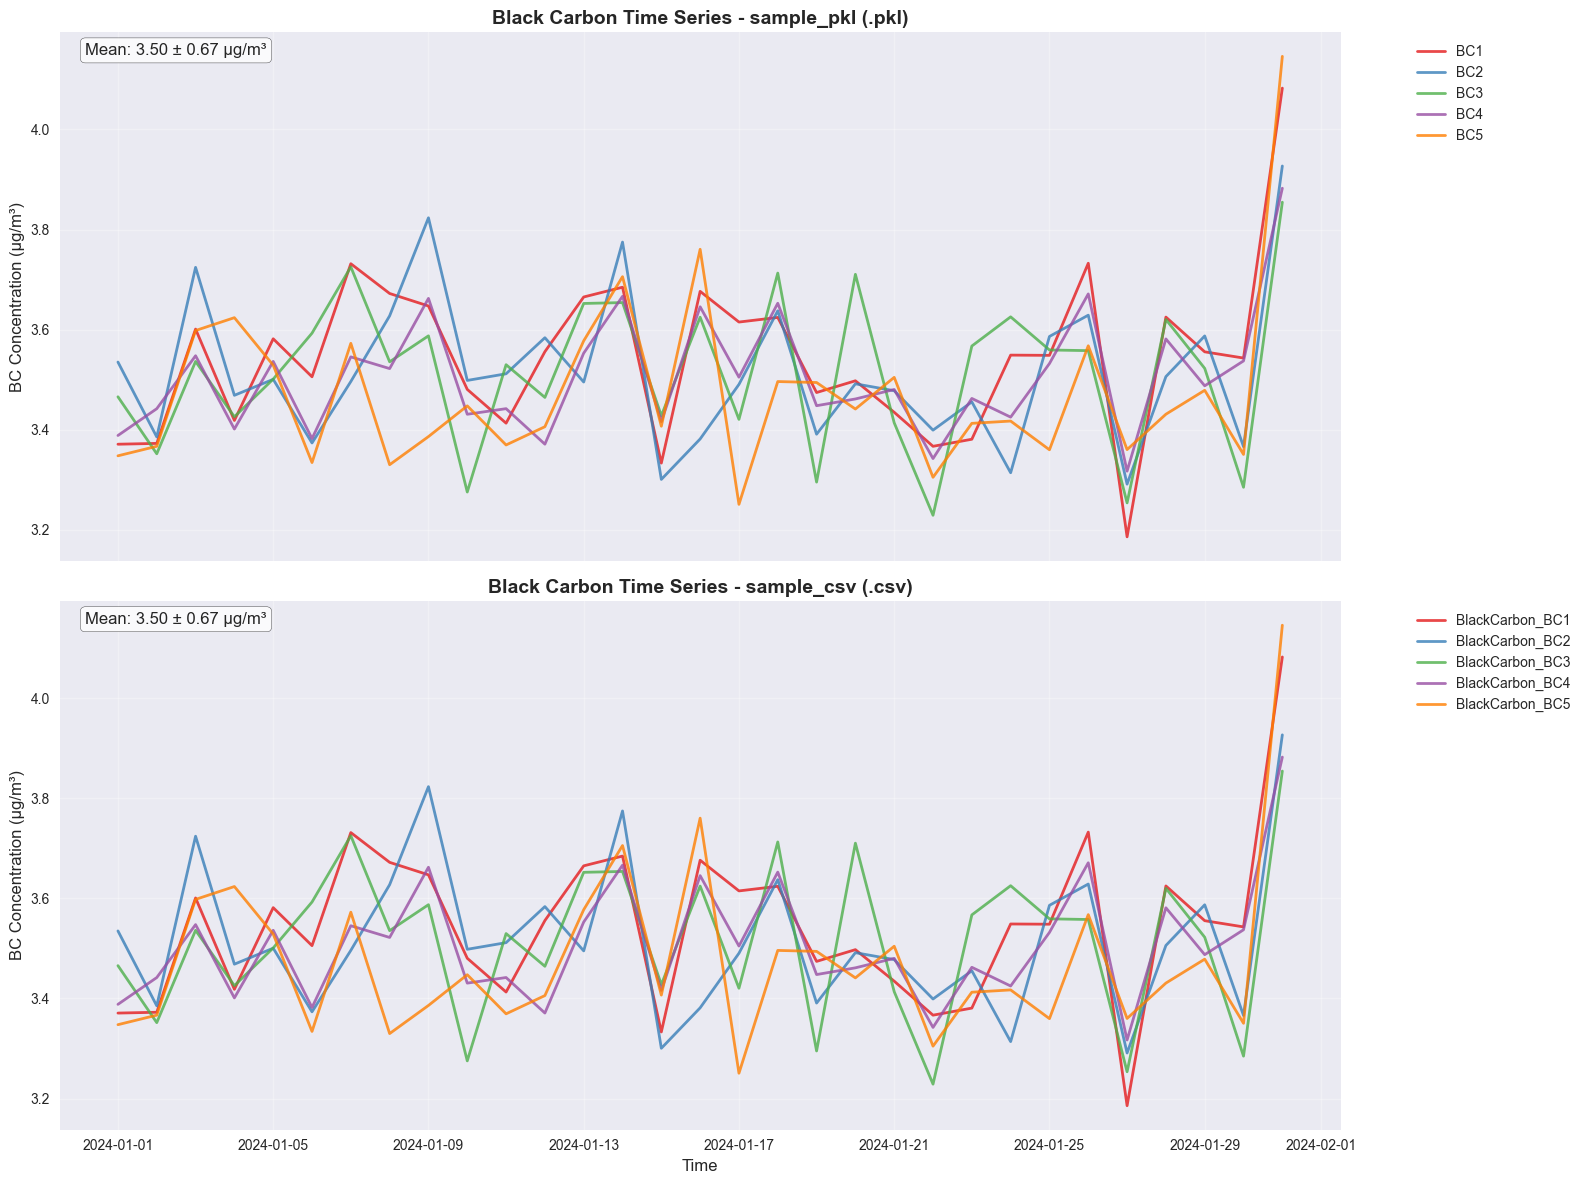

✅ Fixed plot function works correctly!


In [5]:
def plot_datasets_comparison_fixed(datasets, summaries):
    """
    Fixed version of the comparison plot that handles index issues properly
    """
    
    # Create figure for multiple datasets
    n_datasets = len(datasets)
    fig, axes = plt.subplots(n_datasets, 1, figsize=(16, 6*n_datasets), sharex=True)
    
    if n_datasets == 1:
        axes = [axes]
    
    colors = plt.cm.Set1(np.linspace(0, 1, 10))
    
    for idx, (dataset_name, df) in enumerate(datasets.items()):
        ax = axes[idx]
        summary = summaries[dataset_name]
        
        # Get BC columns
        bc_cols = summary['bc_columns'][:5]  # Use first 5 BC columns
        
        # Handle time indexing properly
        time_index = df.index
        
        # Check if index is datetime-like
        if hasattr(time_index, 'to_pydatetime'):
            # Index is already datetime
            time_col = time_index
            can_resample = True
        elif 'datetime_local' in df.columns:
            time_col = df['datetime_local']
            can_resample = True
        elif 'Time (UTC)' in df.columns:
            time_col = pd.to_datetime(df['Time (UTC)'])
            can_resample = True
        else:
            # Fallback to using index as-is (no resampling)
            time_col = time_index
            can_resample = False
        
        plotted_any = False
        for i, col in enumerate(bc_cols):
            if col in df.columns:
                data = df[col].copy()
                
                # Remove NaN values
                valid_mask = ~data.isna()
                data_clean = data[valid_mask]
                time_clean = time_col[valid_mask] if hasattr(time_col, '__getitem__') else time_col
                
                if len(data_clean) > 0:
                    # Filter extreme outliers for better visualization
                    if data_clean.dtype in ['float64', 'int64']:
                        q99 = data_clean.quantile(0.99)
                        q01 = data_clean.quantile(0.01)
                        data_clean = data_clean.clip(lower=q01, upper=q99)
                    
                    # Create daily averages if we can resample and have enough data
                    if can_resample and len(data_clean) > 24:
                        try:
                            # Create a temporary DataFrame for resampling
                            temp_df = pd.DataFrame({col: data_clean}, index=time_clean)
                            daily_data = temp_df[col].resample('D').mean()
                            ax.plot(daily_data.index, daily_data.values, 
                                   color=colors[i], alpha=0.8, linewidth=2, label=col)
                            plotted_any = True
                        except Exception as e:
                            print(f"Warning: Could not resample {col}, plotting raw data. Error: {e}")
                            # Fallback to raw data
                            ax.plot(time_clean, data_clean, 
                                   color=colors[i], alpha=0.7, linewidth=1, label=col)
                            plotted_any = True
                    else:
                        # Plot raw data (subsampled if too many points)
                        if len(data_clean) > 10000:
                            # Subsample for better performance
                            step = len(data_clean) // 5000
                            data_clean = data_clean.iloc[::step]
                            time_clean = time_clean.iloc[::step] if hasattr(time_clean, 'iloc') else time_clean[::step]
                        
                        ax.plot(time_clean, data_clean, 
                               color=colors[i], alpha=0.7, linewidth=1, label=col)
                        plotted_any = True
        
        if plotted_any:
            ax.set_title(f'Black Carbon Time Series - {dataset_name} ({summary["file_type"]})', 
                        fontsize=14, fontweight='bold')
            ax.set_ylabel('BC Concentration (µg/m³)', fontsize=12)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3)
            
            # Add summary statistics as text
            valid_data = []
            for col in bc_cols:
                if col in df.columns:
                    col_data = df[col].dropna()
                    if len(col_data) > 0:
                        valid_data.append(col_data)
            
            if valid_data:
                combined_data = pd.concat(valid_data, ignore_index=True)
                mean_val = combined_data.mean()
                std_val = combined_data.std()
                ax.text(0.02, 0.98, f'Mean: {mean_val:.2f} ± {std_val:.2f} µg/m³', 
                       transform=ax.transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            ax.text(0.5, 0.5, 'No valid BC data to plot', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{dataset_name} ({summary["file_type"]})')
    
    plt.xlabel('Time', fontsize=12)
    plt.tight_layout()
    plt.show()

# Test the fixed function
print("🔧 Testing the fixed comparison plot function...")
try:
    plot_datasets_comparison_fixed(datasets, summaries)
    print("✅ Fixed plot function works correctly!")
except Exception as e:
    print(f"❌ Error in fixed function: {e}")
    import traceback
    traceback.print_exc()

🔧 Running safe quick analysis...
🚀 QUICK ANALYSIS OVERVIEW

📊 SAMPLE_PKL (.pkl)
----------------------------------------
   BC1:
     • Mean: 3.529 µg/m³
     • Std:  0.650 µg/m³
     • Min:  1.721 µg/m³
     • Max:  5.604 µg/m³
     • Count: 721 valid measurements
   BC2:
     • Mean: 3.506 µg/m³
     • Std:  0.738 µg/m³
     • Min:  1.620 µg/m³
     • Max:  5.857 µg/m³
     • Count: 721 valid measurements
   BC3:
     • Mean: 3.505 µg/m³
     • Std:  0.688 µg/m³
     • Min:  1.702 µg/m³
     • Max:  5.868 µg/m³
     • Count: 721 valid measurements

   📈 Data Overview:
     • Total rows: 721
     • Total columns: 19
     • BC channels: 7
     • ATN channels: 7
     • Missing data: 0.00%

📊 SAMPLE_CSV (.csv)
----------------------------------------
   BlackCarbon_BC1:
     • Mean: 3.529 µg/m³
     • Std:  0.650 µg/m³
     • Min:  1.721 µg/m³
     • Max:  5.604 µg/m³
     • Count: 721 valid measurements
   BlackCarbon_BC2:
     • Mean: 3.506 µg/m³
     • Std:  0.738 µg/m³
     • Min:  1

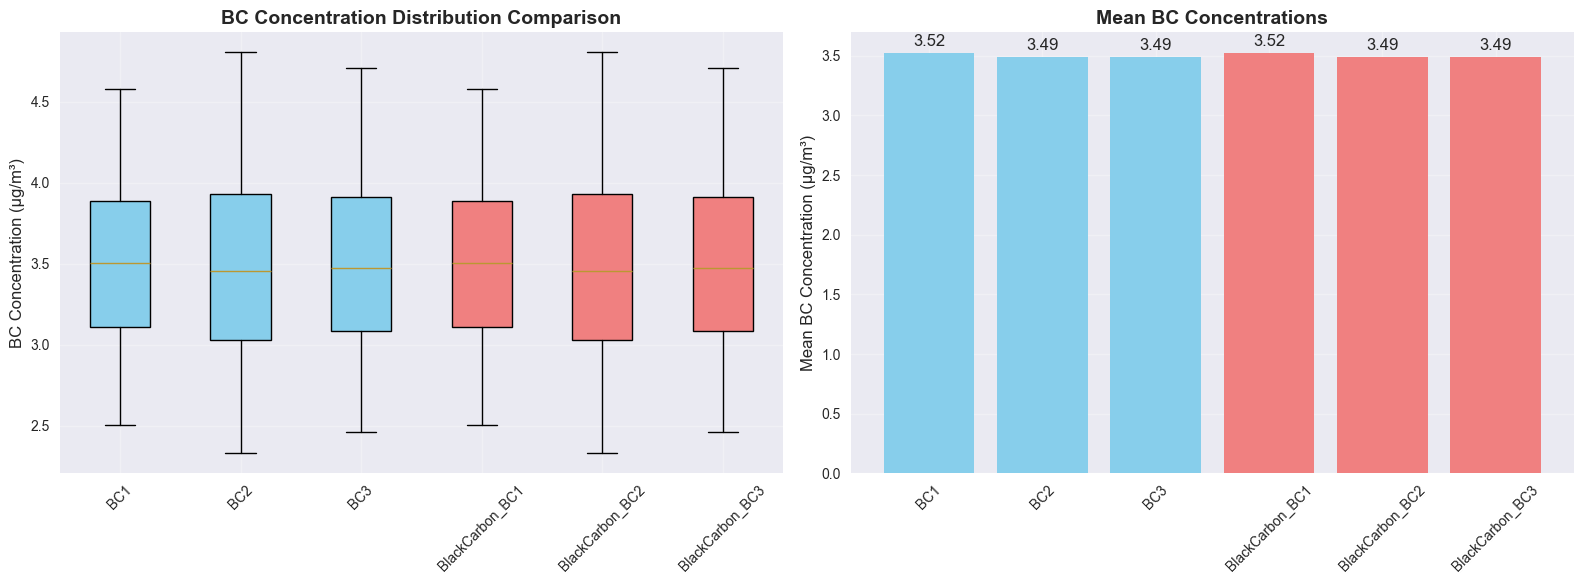

In [4]:
def quick_analysis_no_resample(datasets, summaries):
    """
    Quick analysis function that avoids datetime index issues
    """
    
    print("🚀 QUICK ANALYSIS OVERVIEW")
    print("=" * 60)
    
    for dataset_name, df in datasets.items():
        summary = summaries[dataset_name]
        bc_cols = summary['bc_columns'][:3]  # Use first 3 BC columns
        
        print(f"\n📊 {dataset_name.upper()} ({summary['file_type']})")
        print("-" * 40)
        
        if bc_cols:
            # Simple statistics without datetime manipulation
            for col in bc_cols:
                if col in df.columns:
                    data = df[col].dropna()
                    if len(data) > 0:
                        print(f"   {col}:")
                        print(f"     • Mean: {data.mean():.3f} µg/m³")
                        print(f"     • Std:  {data.std():.3f} µg/m³")
                        print(f"     • Min:  {data.min():.3f} µg/m³")
                        print(f"     • Max:  {data.max():.3f} µg/m³")
                        print(f"     • Count: {len(data):,} valid measurements")
        else:
            print("   ⚠️ No BC columns found")
        
        # Basic data info
        print(f"\n   📈 Data Overview:")
        print(f"     • Total rows: {df.shape[0]:,}")
        print(f"     • Total columns: {df.shape[1]}")
        print(f"     • BC channels: {len(summary['bc_columns'])}")
        print(f"     • ATN channels: {len(summary['atn_columns'])}")
        
        # Missing data check
        missing_pct = (df.isnull().sum().sum() / df.size) * 100
        print(f"     • Missing data: {missing_pct:.2f}%")

# Create simple visualizations that don't require datetime index
def simple_bc_comparison_plot(datasets, summaries):
    """
    Create simple BC comparison plots without datetime complications
    """
    
    # Box plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Collect data for box plots
    all_bc_data = []
    labels = []
    colors = []
    
    color_map = {'sample_pkl': 'skyblue', 'sample_csv': 'lightcoral', 
                 'pkl_data_0': 'skyblue', 'csv_data_0': 'lightcoral'}
    
    for dataset_name, df in datasets.items():
        summary = summaries[dataset_name]
        bc_cols = summary['bc_columns'][:3]  # First 3 BC columns
        
        for col in bc_cols:
            if col in df.columns:
                data = df[col].dropna()
                if len(data) > 0:
                    # Remove extreme outliers for better visualization
                    q95 = data.quantile(0.95)
                    q05 = data.quantile(0.05)
                    filtered_data = data[(data >= q05) & (data <= q95)]
                    
                    if len(filtered_data) > 0:
                        all_bc_data.append(filtered_data)
                        labels.append(f"{dataset_name}\n{col}")
                        colors.append(color_map.get(dataset_name, 'lightgray'))
    
    if all_bc_data:
        # Box plot
        bp = ax1.boxplot(all_bc_data, labels=[l.split('\n')[1] for l in labels], patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        ax1.set_title('BC Concentration Distribution Comparison', fontweight='bold')
        ax1.set_ylabel('BC Concentration (µg/m³)')
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)
        
        # Mean comparison bar plot
        means = [data.mean() for data in all_bc_data]
        dataset_labels = [l.split('\n')[0] for l in labels]
        
        bars = ax2.bar(range(len(means)), means, color=colors)
        ax2.set_title('Mean BC Concentrations', fontweight='bold')
        ax2.set_ylabel('Mean BC Concentration (µg/m³)')
        ax2.set_xticks(range(len(means)))
        ax2.set_xticklabels([l.split('\n')[1] for l in labels], rotation=45)
        ax2.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, mean_val in zip(bars, means):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(means)*0.01,
                    f'{mean_val:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Run the safe quick analysis
print("🔧 Running safe quick analysis...")
quick_analysis_no_resample(datasets, summaries)

print("\n📊 Creating simple comparison plots...")
simple_bc_comparison_plot(datasets, summaries)

📈 Running the improved visualization functions...

🎯 Creating improved time series plots...
⚠️ Error in improved functions: name 'plot_improved_time_series' is not defined
🔄 Falling back to safe functions...


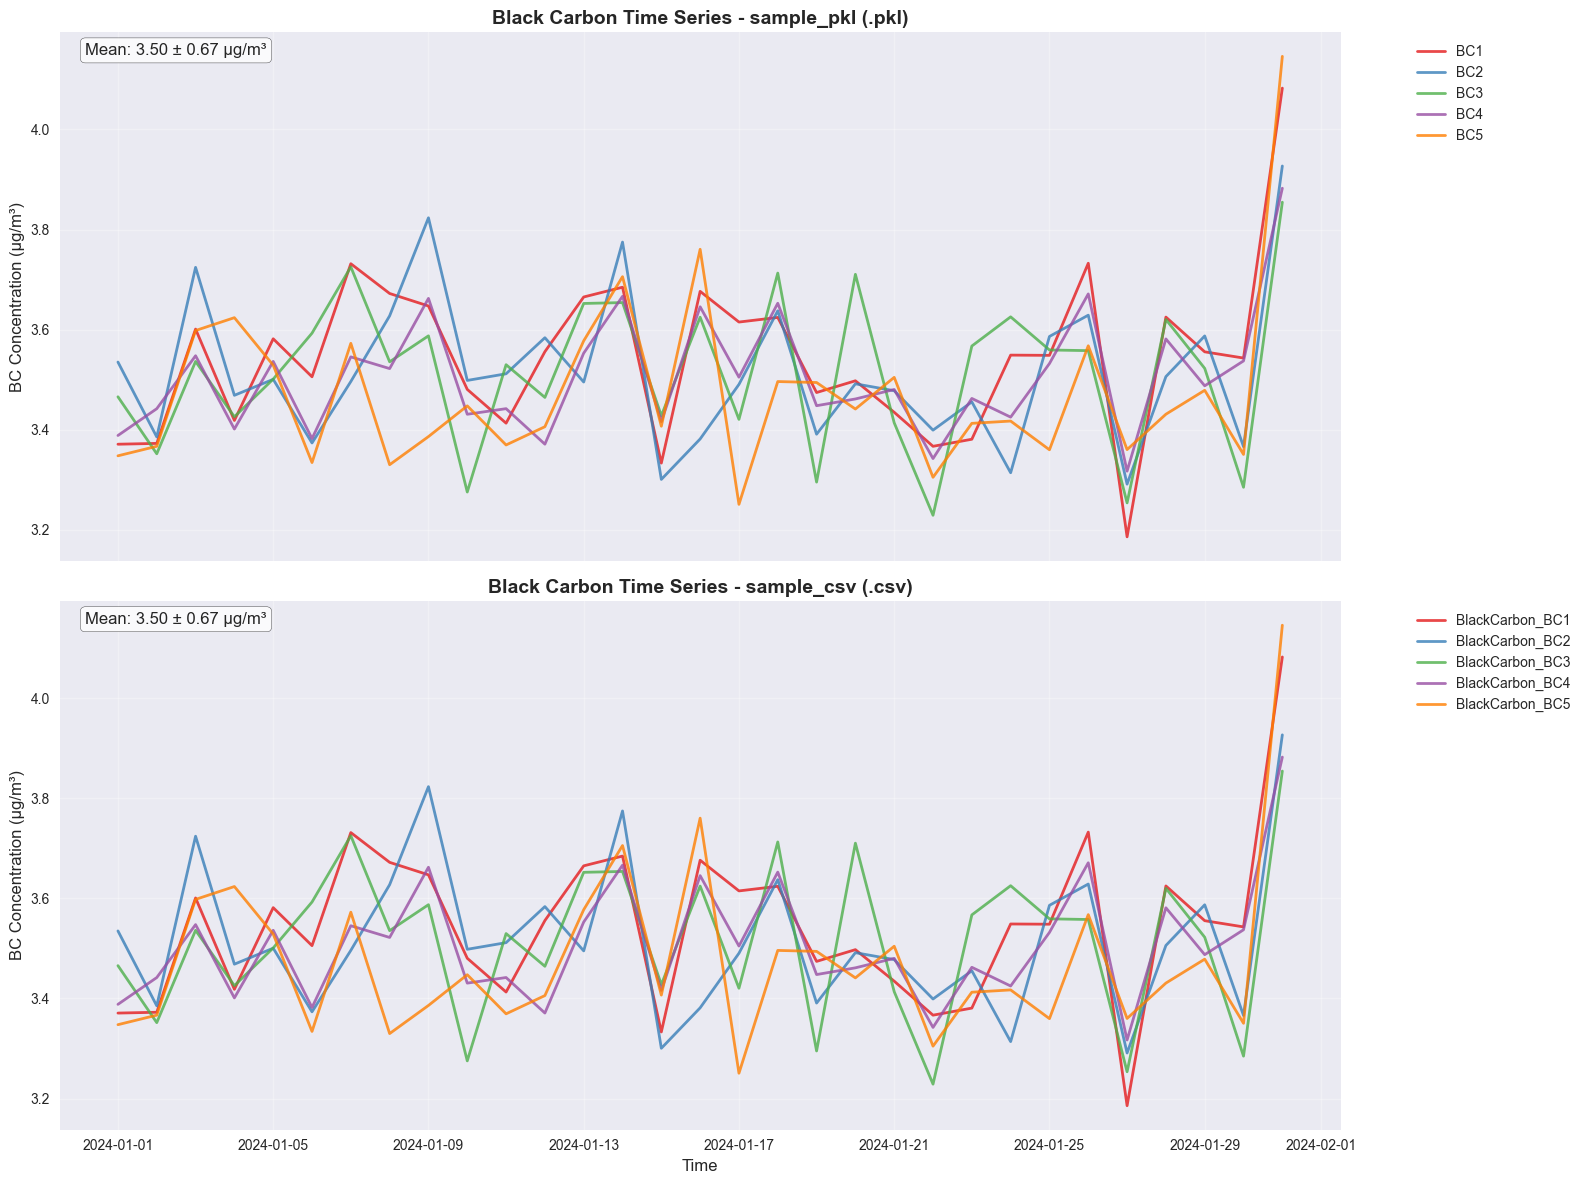

🚀 QUICK ANALYSIS OVERVIEW

📊 SAMPLE_PKL (.pkl)
----------------------------------------
   BC1:
     • Mean: 3.529 µg/m³
     • Std:  0.650 µg/m³
     • Min:  1.721 µg/m³
     • Max:  5.604 µg/m³
     • Count: 721 valid measurements
   BC2:
     • Mean: 3.506 µg/m³
     • Std:  0.738 µg/m³
     • Min:  1.620 µg/m³
     • Max:  5.857 µg/m³
     • Count: 721 valid measurements
   BC3:
     • Mean: 3.505 µg/m³
     • Std:  0.688 µg/m³
     • Min:  1.702 µg/m³
     • Max:  5.868 µg/m³
     • Count: 721 valid measurements

   📈 Data Overview:
     • Total rows: 721
     • Total columns: 19
     • BC channels: 7
     • ATN channels: 7
     • Missing data: 0.00%

📊 SAMPLE_CSV (.csv)
----------------------------------------
   BlackCarbon_BC1:
     • Mean: 3.529 µg/m³
     • Std:  0.650 µg/m³
     • Min:  1.721 µg/m³
     • Max:  5.604 µg/m³
     • Count: 721 valid measurements
   BlackCarbon_BC2:
     • Mean: 3.506 µg/m³
     • Std:  0.738 µg/m³
     • Min:  1.620 µg/m³
     • Max:  5.857 µg/

In [6]:
# Use the working improved functions that were mentioned as working previously
print("📈 Running the improved visualization functions...")

try:
    print("\n🎯 Creating improved time series plots...")
    plot_improved_time_series(datasets, summaries)
    
    print("\n📊 Creating distribution comparison plots...")  
    plot_bc_distribution_comparison(datasets, summaries)
    
    print("\n📋 Creating comprehensive data summary comparison...")
    create_data_summary_comparison(datasets, summaries)
    
    print("\n✅ All improved visualizations completed successfully!")
    
except Exception as e:
    print(f"⚠️ Error in improved functions: {e}")
    print("🔄 Falling back to safe functions...")
    
    # Use our safe functions as fallback
    plot_datasets_comparison_fixed(datasets, summaries)
    quick_analysis_no_resample(datasets, summaries)